## === Research Zone ===

### 1. Import Libraries

In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import networkx as nx
import numpy as np
import copy
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from ipycytoscape import CytoscapeWidget
from cdlib import algorithms, viz, readwrite
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'karateclub', 'wurlitzer', 'infomap'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'wurlitzer', 'infomap'}


### 2. Load Adjacency Matrix from Wang, Jiang, and Lin Method

In [2]:
df_wang = pd.read_excel('./../data/adjmatrix-Wang.xlsx')
df_jiang = pd.read_excel('./../data/adjmatrix-Jiang.xlsx')
df_lin = pd.read_excel('./../data/adjmatrix-Lin.xlsx')

### 3. Drop Row and Column with NAN Values

In [3]:
df_wang = df_wang.dropna(axis=0, thresh=3)
df_wang = df_wang.dropna(axis=1, thresh=3)
print(len(df_wang))

df_jiang = df_jiang.dropna(axis=0, thresh=3)
df_jiang = df_jiang.dropna(axis=1, thresh=3)
print(len(df_jiang))

df_lin = df_lin.dropna(axis=0, thresh=3)
df_lin = df_lin.dropna(axis=1, thresh=3)
print(len(df_lin))

845
845
845


### 4. Plot Wang, Jiang, and Lin Graphs' Edges Count

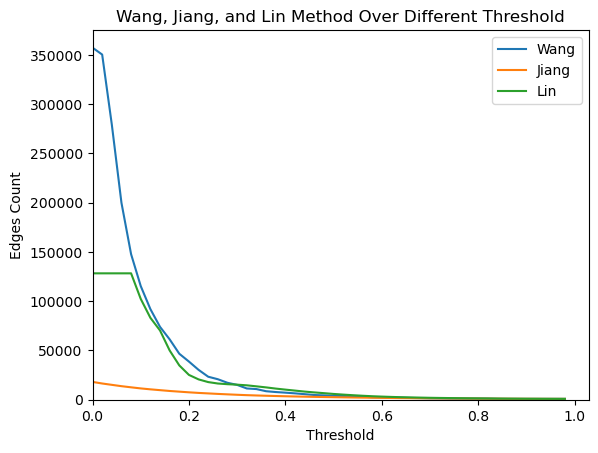

In [4]:
threshold_list = []
edges_list_wang = []
edges_list_jiang = []
edges_list_lin = []

for i in np.arange(0, 1, 0.02):
    k = copy.deepcopy(df_wang)
    k[k < i] = 0
    graph = nx.from_numpy_matrix(k.values)
    graph = nx.relabel_nodes(graph, dict(enumerate(k.columns)))
    edges = graph.number_of_edges()
    threshold_list.append(i)
    edges_list_wang.append(edges)
    
    k = copy.deepcopy(df_jiang)
    k[k < i] = 0
    graph = nx.from_numpy_matrix(k.values)
    graph = nx.relabel_nodes(graph, dict(enumerate(k.columns)))
    edges = graph.number_of_edges()
    edges_list_jiang.append(edges)
    
    k = copy.deepcopy(df_lin)
    k[k < i] = 0
    graph = nx.from_numpy_matrix(k.values)
    graph = nx.relabel_nodes(graph, dict(enumerate(k.columns)))
    edges = graph.number_of_edges()
    edges_list_lin.append(edges)

plt.title("Wang, Jiang, and Lin Method Over Different Threshold")
plt.plot(threshold_list, edges_list_wang)
plt.plot(threshold_list, edges_list_jiang)
plt.plot(threshold_list, edges_list_lin)
plt.xlim(0)
plt.ylim(0)
plt.xlabel("Threshold")
plt.ylabel("Edges Count")
plt.legend(['Wang', 'Jiang', 'Lin'])
plt.show()

### 5. Choose Wang Method with Threshold = 0.5, Make The Graph and See The Nodes Degree Distribution

Nodes that will be used as giant component: 323


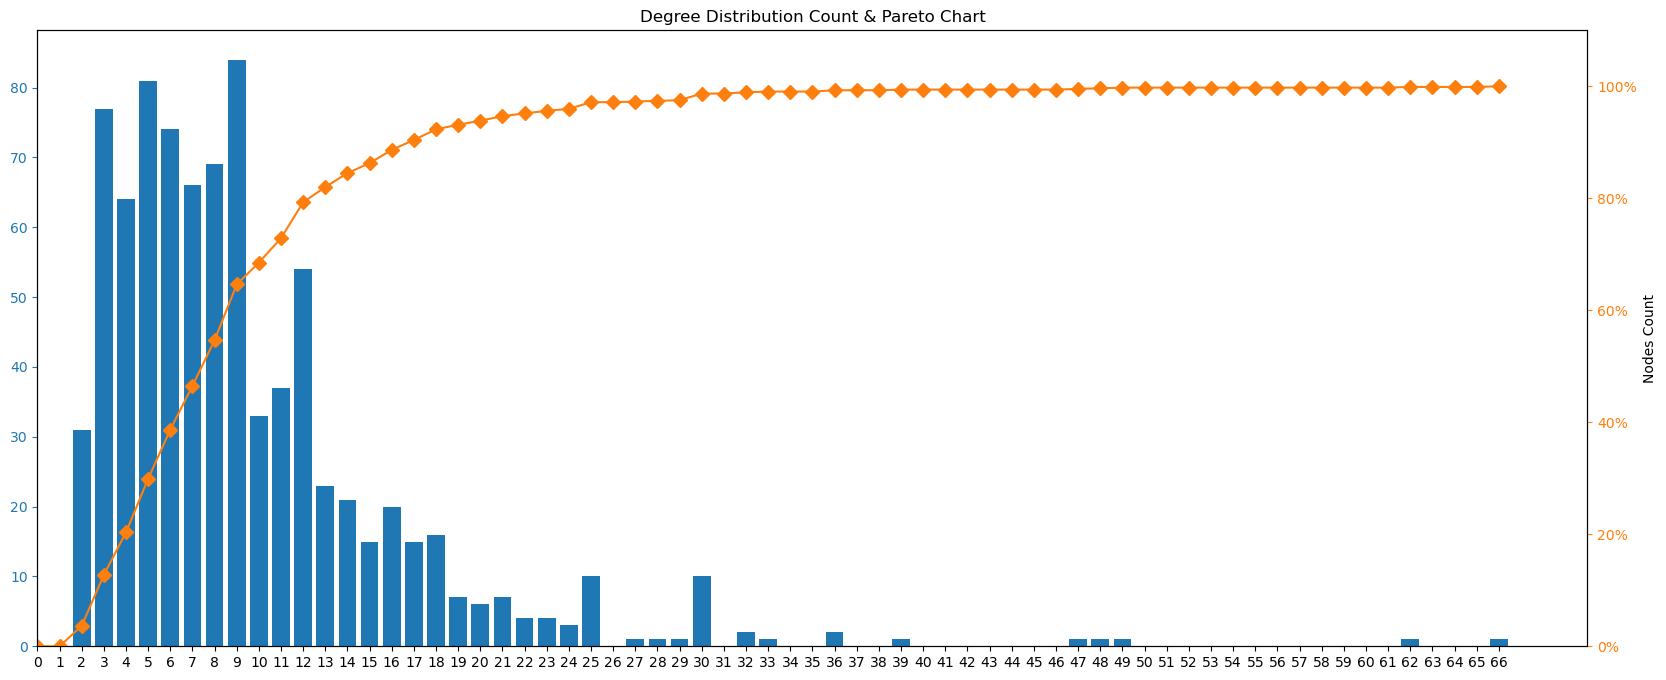

In [5]:
df_wang[df_wang < 0.5] = 0

graph = nx.from_numpy_matrix(df_wang.values)
graph = nx.relabel_nodes(graph, dict(enumerate(df_wang.columns)))

nx.write_edgelist(graph, "full_graph.edgelist", data=False)

nodes_of_largest_component  = max(nx.connected_components(graph), key = len)
print("Nodes that will be used as giant component: " + str(len(nodes_of_largest_component)))
g = graph.subgraph(nodes_of_largest_component)
nx.write_edgelist(g, "giant_subgraph.edgelist", data=False)
overall_density = nx.density(g)

degree = graph.degree()

degree_dic = {}
for nodes, deg in degree:
    if deg not in degree_dic:
        degree_dic[deg] = 1
    else:
        degree_dic[deg] += 1

for i in range(0, 67):
    if i not in degree_dic:
        degree_dic[i] = 0
k = sorted(degree_dic.items())
    
data = pd.DataFrame(k, columns =['Degree', 'Count'])
data["cumpercentage"] = data["Count"].cumsum()/data["Count"].sum()*100

fig, ax = plt.subplots(figsize=(20, 8))
ax.bar(data["Degree"], data["Count"], color="C0")
ax2 = ax.twinx()
ax2.plot(data["Degree"], data["cumpercentage"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
plt.xlim(0, 70)
plt.ylim(0, 110)
plt.xlabel("Degree")
plt.ylabel("Nodes Count")
plt.title("Degree Distribution Count & Pareto Chart")
plt.xticks(range(0, 67))
plt.show()

### 6. Plot The Largest Component Beside The Rest of The Graph w/ Cytoscape Widget

In [6]:
cyto = CytoscapeWidget()

for node in g.nodes(data=True):
    node[1]["classes"] = 'classRey'
    
for s, t, data in g.edges(data=True):
    g[s][t]['classes'] = 'classRey'
    
cyto.graph.add_graph_from_networkx(graph)
cyto.set_style(
    [
        {
             'selector': 'node.classRey',
             'style': {
                 'background-color': 'green'
             }
        },
        {
             'selector': 'edge.classRey',
             'style': {
                 'line-color': '#A0FFA0'
             }
        }
    ]
)
display(cyto)

### 7. Plot The Larget Component On Its Own w/ Cytoscape Widget

In [7]:
cyto_largest = CytoscapeWidget()
cyto_largest.graph.add_graph_from_networkx(g)
cyto_largest.set_style(
    [
        {
             'selector': 'node',
             'style': {
                 'background-color': 'green'
             }
        },
        {
             'selector': 'edge',
             'style': {
                 'line-color': '#A0FFA0'
             }
        }
    ]
)
display(cyto_largest)

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'style': {'background…

### 8. Initialize The Position of Graph and Get The Communities with All Algorithms

In [8]:
random_pos = nx.random_layout(g, seed=42)

coms_af = algorithms.async_fluid(g, k=7)
coms_bel = algorithms.belief(g)
coms_cpm = algorithms.cpm(g)
coms_cw = algorithms.chinesewhispers(nx.Graph(g))
coms_der = algorithms.der(g)
coms_ev = algorithms.eigenvector(g)
coms_em = algorithms.em(nx.Graph(g), k=10)
coms_ga = algorithms.ga(g)
coms_gn = algorithms.girvan_newman(g, level=5)
coms_gm = algorithms.greedy_modularity(g)
coms_kc = algorithms.kcut(nx.Graph(g), kmax=4)
coms_lp = algorithms.label_propagation(g)
coms_lei = algorithms.leiden(g)
coms_lou = algorithms.louvain(g)
coms_mc = algorithms.markov_clustering(nx.Graph(g))
coms_rber = algorithms.rber_pots(g)
coms_rbp = algorithms.rb_pots(g)
coms_sic = algorithms.significance_communities(g)
coms_sg = algorithms.spinglass(g)
coms_sc = algorithms.surprise_communities(g)
coms_wt = algorithms.walktrap(g)

readwrite.write_community_csv(coms_lei, "leiden-communities.csv", ",")
readwrite.write_community_csv(coms_sg, "spinglass-communities.csv", ",")
readwrite.write_community_csv(coms_rber, "rberpots-communities.csv", ",")
readwrite.write_community_csv(coms_rbp, "rbpots-communities.csv", ",")
readwrite.write_community_csv(coms_lou, "louvain-communities.csv", ",")
readwrite.write_community_csv(coms_wt, "walktrap-communities.csv", ",")
readwrite.write_community_csv(coms_gn, "girvannewman-communities.csv", ",")
readwrite.write_community_csv(coms_bel, "belief-communities.csv", ",")

### 9.a.1. Using Async Fluid as Community Algorithm - Network Cluster

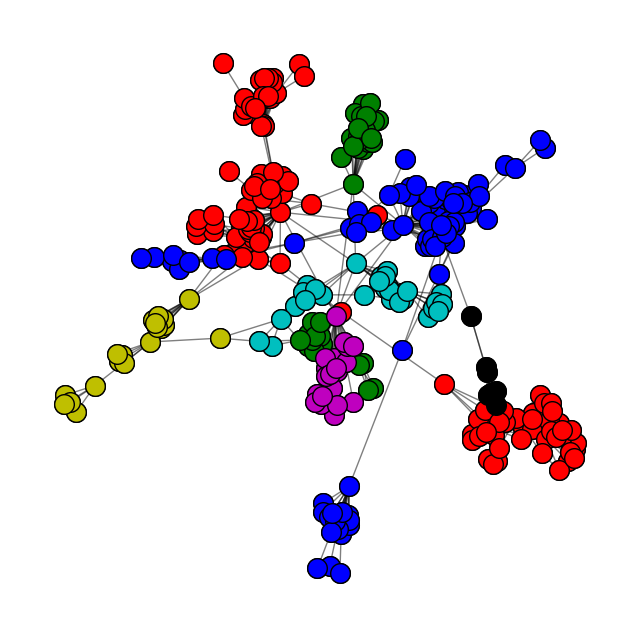

In [9]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_af, pos)

### 9.a.2. Plot the Community Graph

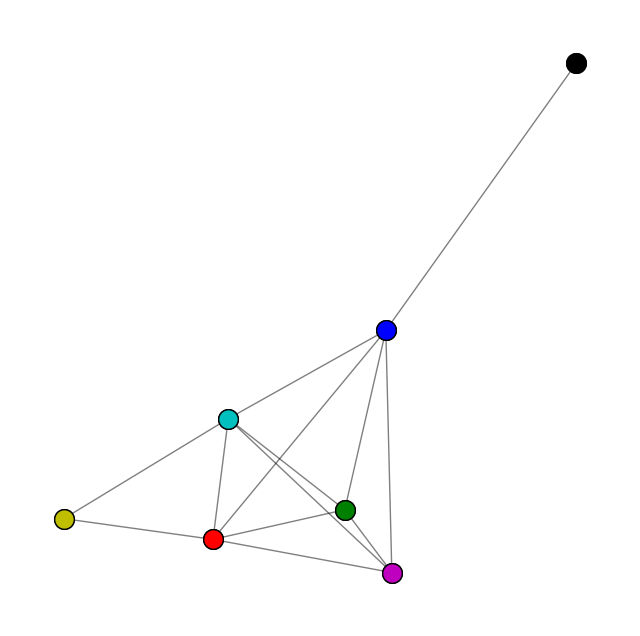

In [10]:
viz.plot_community_graph(g, coms_af)

### 9.a.3. Evaluate the Modularity

In [11]:
from cdlib import evaluation

algorithm = "async fluid"
m1 = evaluation.erdos_renyi_modularity(g, coms_af)
m2 = evaluation.link_modularity(g, coms_af)
m3 = evaluation.modularity_density(g, coms_af)
m4 = evaluation.newman_girvan_modularity(g, coms_af)
m5 = evaluation.z_modularity(g, coms_af)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

eval_table = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

0.7384522907404328
0.10758920494216599
55.29561818213504
0.7365306009116566
1.730083517339979


### 9.b.1. Using Belief as Community Algorithm - Network Cluster

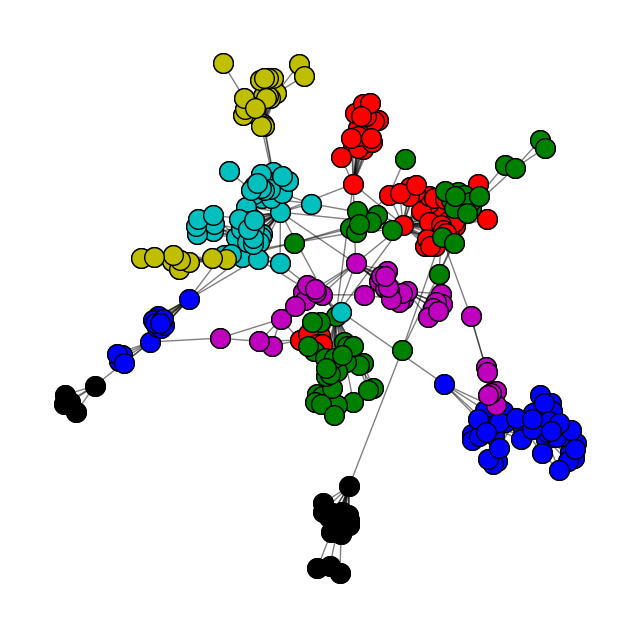

In [12]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_bel, pos)

### 9.b.2. Plot the Community Graph

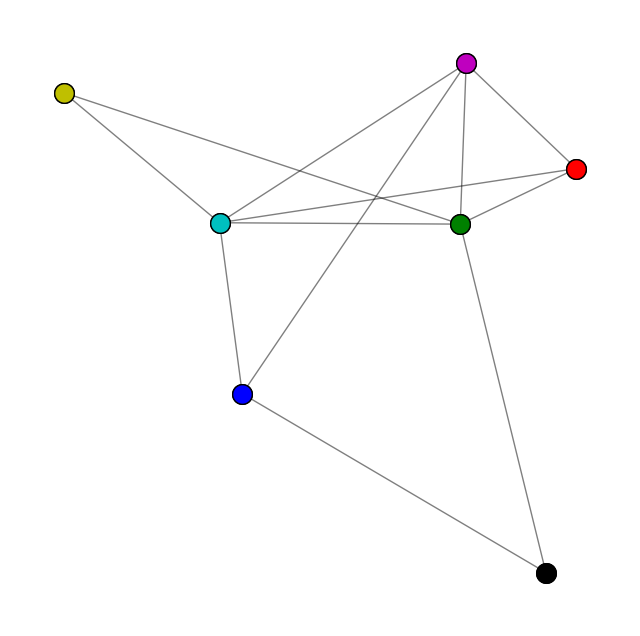

In [13]:
viz.plot_community_graph(g, coms_bel)

### 9.b.3. Evaluate the Modularity

In [14]:
algorithm = "belief"
m1 = evaluation.erdos_renyi_modularity(g, coms_bel)
m2 = evaluation.link_modularity(g, coms_bel)
m3 = evaluation.modularity_density(g, coms_bel)
m4 = evaluation.newman_girvan_modularity(g, coms_bel)
m5 = evaluation.z_modularity(g, coms_bel)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.8156219176011686
0.10676326658685707
57.22178783510276
0.8105630677791585
2.2221217334973247


### 9.c.1. Using CPM as Community Algorithm - Network Cluster

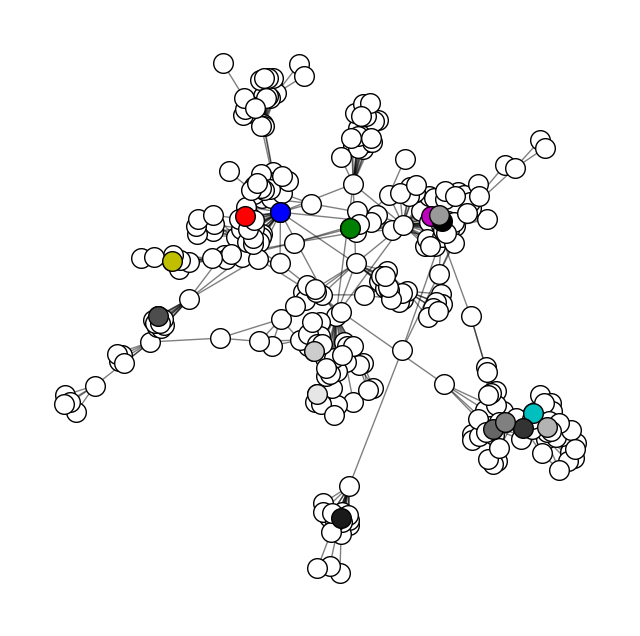

In [15]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_cpm, pos)

### 9.c.2. Plot the Community Graph

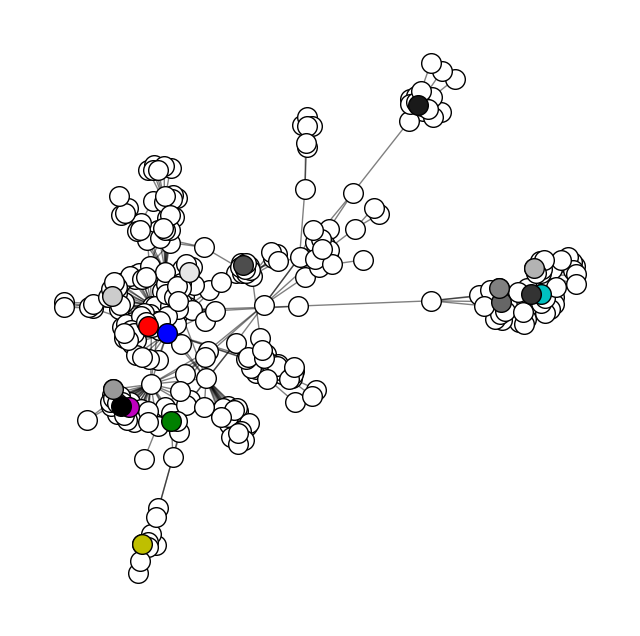

In [16]:
viz.plot_community_graph(g, coms_cpm)

### 9.c.3. Evaluate the Modularity

In [17]:
algorithm = "cpm"
m1 = evaluation.erdos_renyi_modularity(g, coms_cpm)
m2 = evaluation.link_modularity(g, coms_cpm)
m3 = evaluation.modularity_density(g, coms_cpm)
m4 = evaluation.newman_girvan_modularity(g, coms_cpm)
m5 = evaluation.z_modularity(g, coms_cpm)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.2305496074232691
0.0
-1510.0
0.2261862002311999
3.4316485879321283


### 9.d.1. Using Chinese Whispers as Community Algorithm - Network Cluster

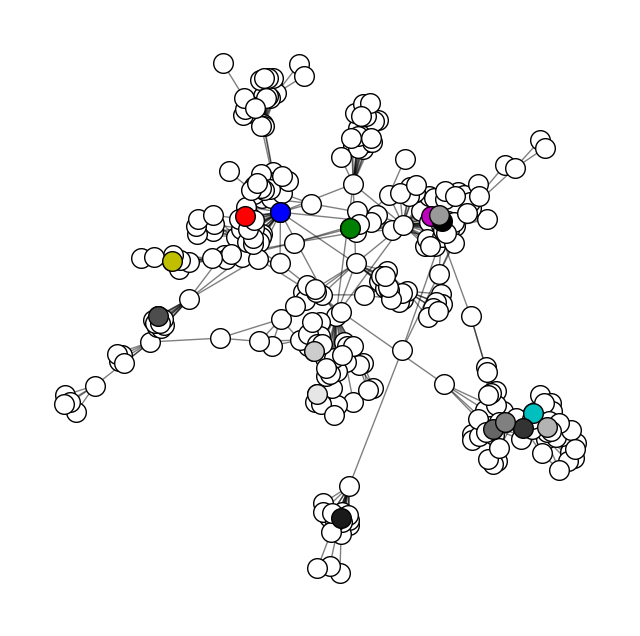

In [18]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_cw, pos)

### 9.d.2. Plot the Community Graph

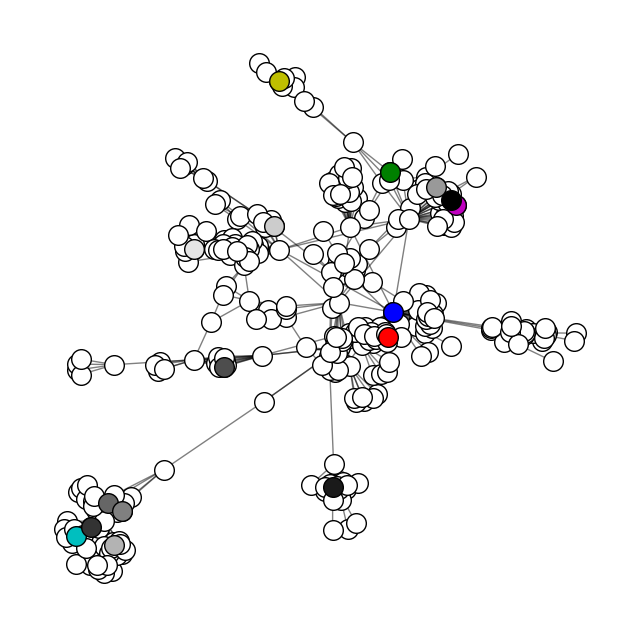

In [19]:
viz.plot_community_graph(g, coms_cw)

### 9.d.3. Evaluate the Modularity

In [20]:
algorithm = "chinese whispers"
m1 = evaluation.erdos_renyi_modularity(g, coms_cw)
m2 = evaluation.link_modularity(g, coms_cw)
m3 = evaluation.modularity_density(g, coms_cw)
m4 = evaluation.newman_girvan_modularity(g, coms_cw)
m5 = evaluation.z_modularity(g, coms_cw)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.2305496074232691
0.0
-1510.0
0.2261862002311999
3.4316485879321283


### 9.e.1. Using DER as Community Algorithm - Network Cluster

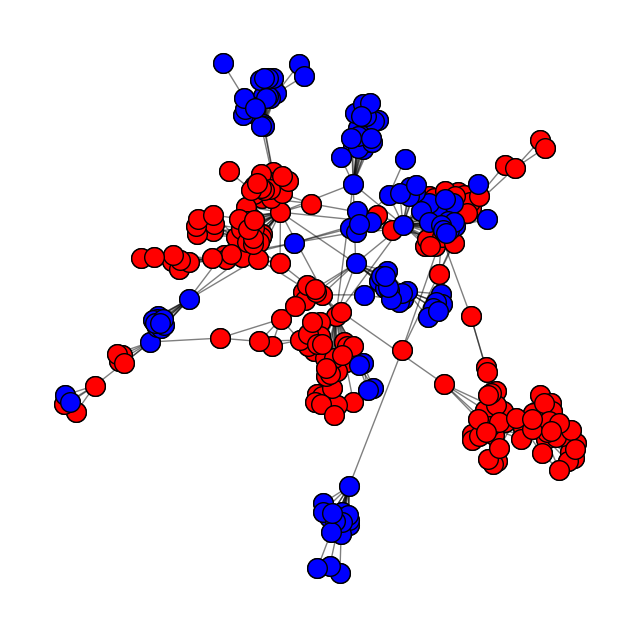

In [21]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_der, pos)

### 9.e.2. Plot the Community Graph

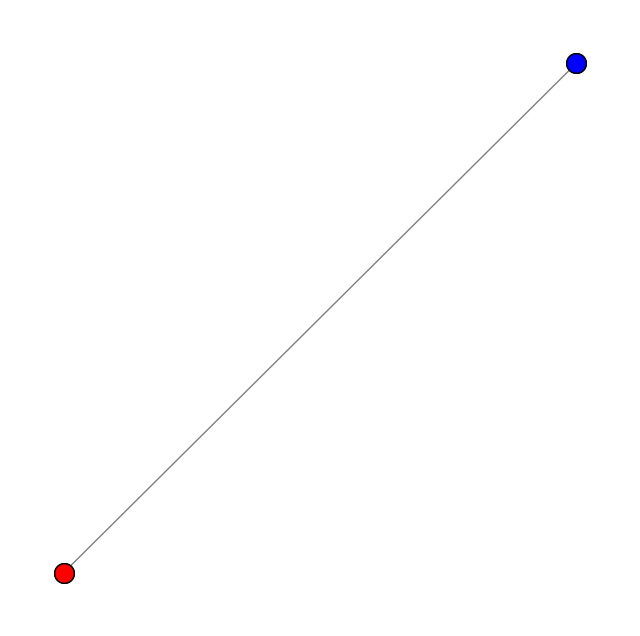

In [22]:
viz.plot_community_graph(g, coms_der)

### 9.e.3. Evaluate the Modularity

In [23]:
algorithm = "der"
m1 = evaluation.erdos_renyi_modularity(g, coms_der)
m2 = evaluation.link_modularity(g, coms_der)
m3 = evaluation.modularity_density(g, coms_der)
m4 = evaluation.newman_girvan_modularity(g, coms_der)
m5 = evaluation.z_modularity(g, coms_der)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.4566686929869238
0.10707290731971378
16.561654135338344
0.4662966342487088
0.9326300162795691


### 9.f.1. Using Eigenvector as Community Algorithm - Network Cluster

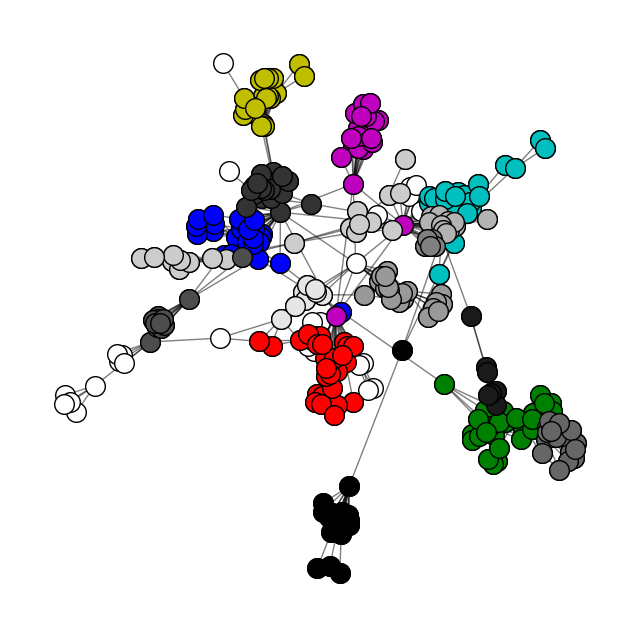

In [24]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_ev, pos)

### 9.f.2. Plot the Community Graph

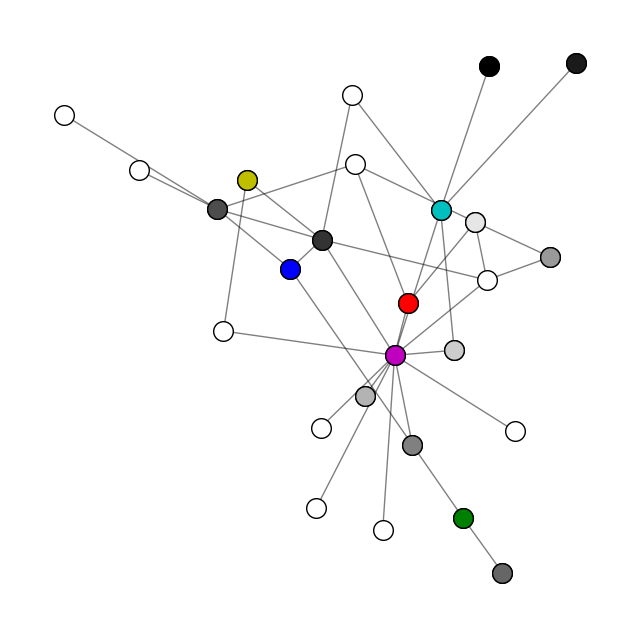

In [25]:
viz.plot_community_graph(g, coms_ev)

### 9.f.3. Evaluate the Modularity

In [26]:
algorithm = "eigenvector"
m1 = evaluation.erdos_renyi_modularity(g, coms_ev)
m2 = evaluation.link_modularity(g, coms_ev)
m3 = evaluation.modularity_density(g, coms_ev)
m4 = evaluation.newman_girvan_modularity(g, coms_ev)
m5 = evaluation.z_modularity(g, coms_ev)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.8397818371072672
0.09664501646886148
122.02863472784526
0.8291650554488206
3.2610074118889814


### 9.g.1. Using EM as Community Algorithm - Network Cluster

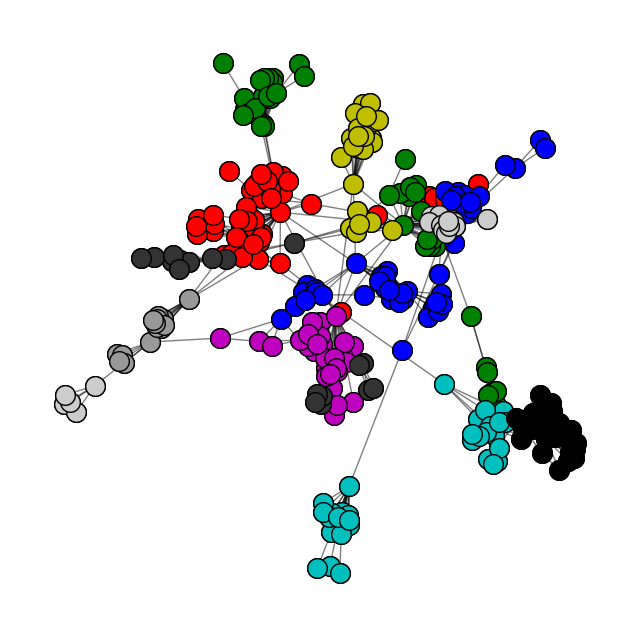

In [27]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_em, pos)

### 9.g.2. Plot the Community Graph

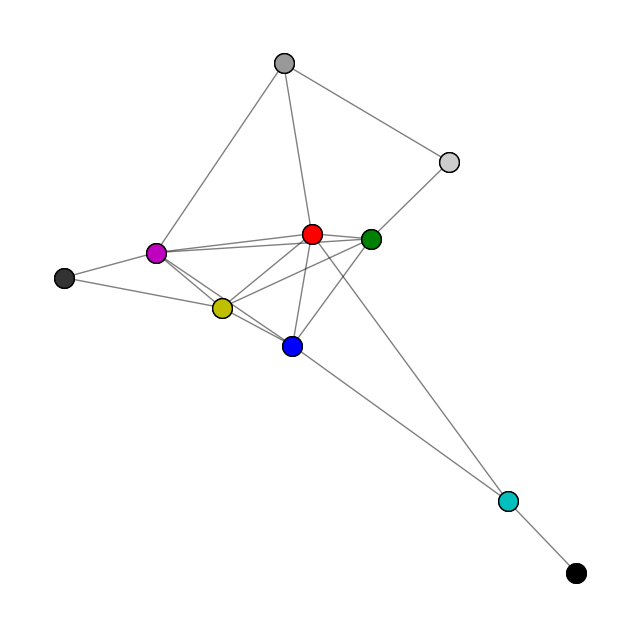

In [28]:
viz.plot_community_graph(g, coms_em)

### 9.g.3. Evaluate the Modularity

In [29]:
algorithm = "em"
m1 = evaluation.erdos_renyi_modularity(g, coms_em)
m2 = evaluation.link_modularity(g, coms_em)
m3 = evaluation.modularity_density(g, coms_em)
m4 = evaluation.newman_girvan_modularity(g, coms_em)
m5 = evaluation.z_modularity(g, coms_em)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.8292698701303444
0.10304628246117732
76.96108895745198
0.8268362406581207
2.581452161657417


### 9.h.1. Using GA as Community Algorithm - Network Cluster

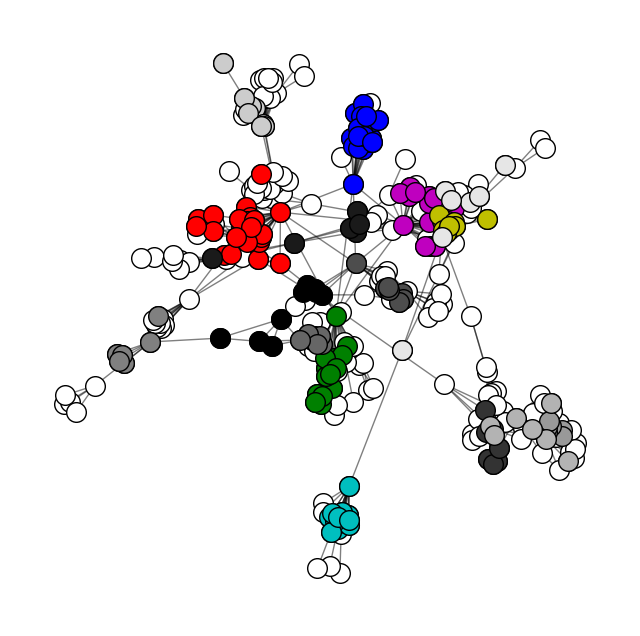

In [30]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_ga, pos)

### 9.h.2. Plot the Community Graph

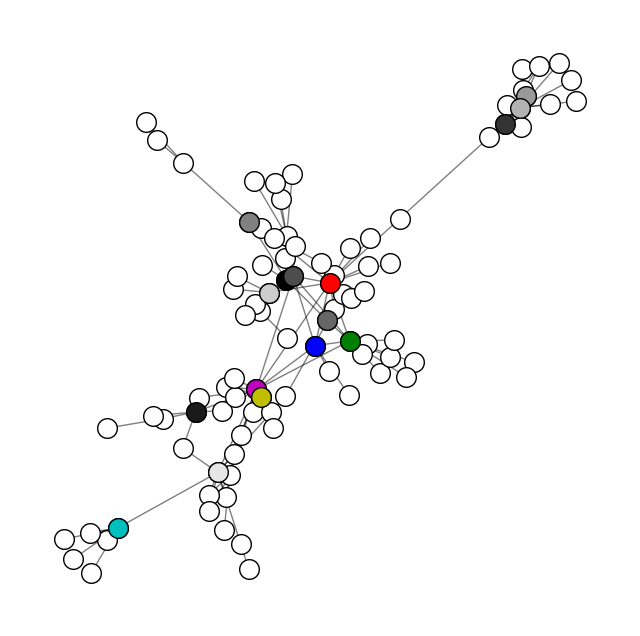

In [31]:
viz.plot_community_graph(g, coms_ga)

### 9.h.3. Evaluate the Modularity

In [32]:
algorithm = "ga"
m1 = evaluation.erdos_renyi_modularity(g, coms_ga)
m2 = evaluation.link_modularity(g, coms_ga)
m3 = evaluation.modularity_density(g, coms_ga)
m4 = evaluation.newman_girvan_modularity(g, coms_ga)
m5 = evaluation.z_modularity(g, coms_ga)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.632747550678698
0.06143571029038817
53.65992063492064
0.6177511118039981
3.2518056068529617


### 9.i.1. Using Girvan Newman as Community Algorithm - Network Cluster

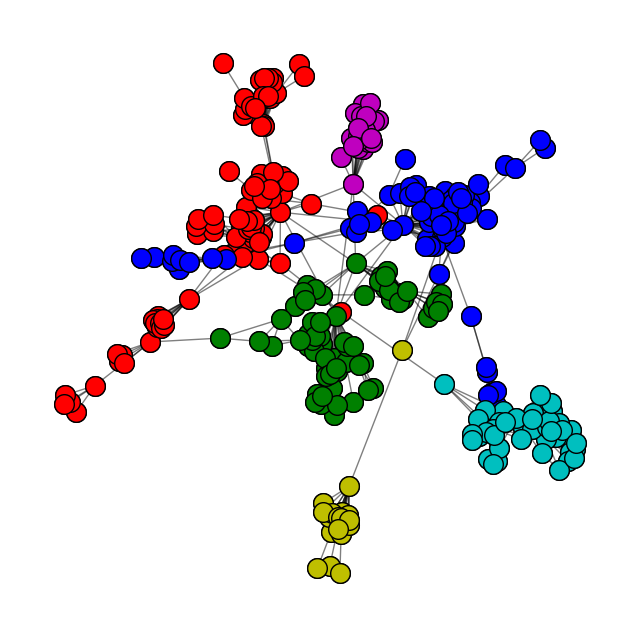

In [33]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_gn, pos)

### 9.i.2. Plot the Community Graph

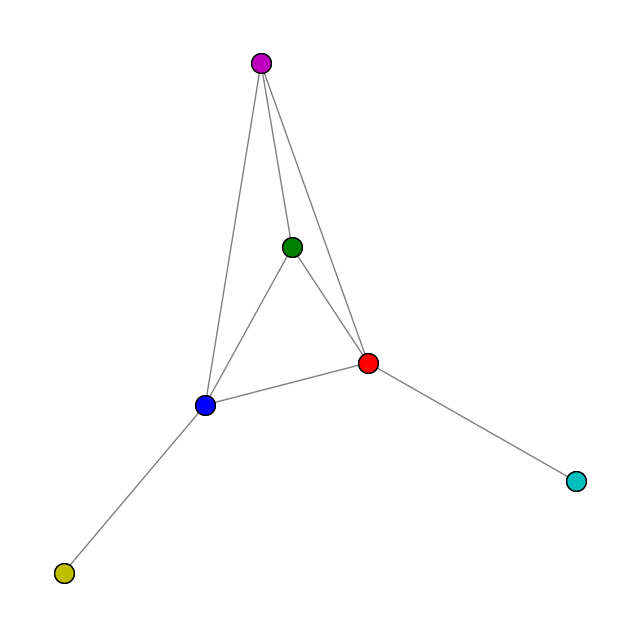

In [34]:
viz.plot_community_graph(g, coms_gn)

### 9.i.3. Evaluate the Modularity

In [35]:
algorithm = "girvan newman"
m1 = evaluation.erdos_renyi_modularity(g, coms_gn)
m2 = evaluation.link_modularity(g, coms_gn)
m3 = evaluation.modularity_density(g, coms_gn)
m4 = evaluation.newman_girvan_modularity(g, coms_gn)
m5 = evaluation.z_modularity(g, coms_gn)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.7848266674012643
0.10986069551772559
54.136951170455006
0.7891350167439287
1.9696240625506558


### 9.j.1. Using Greedy Modularity as Community Algorithm - Network Cluster

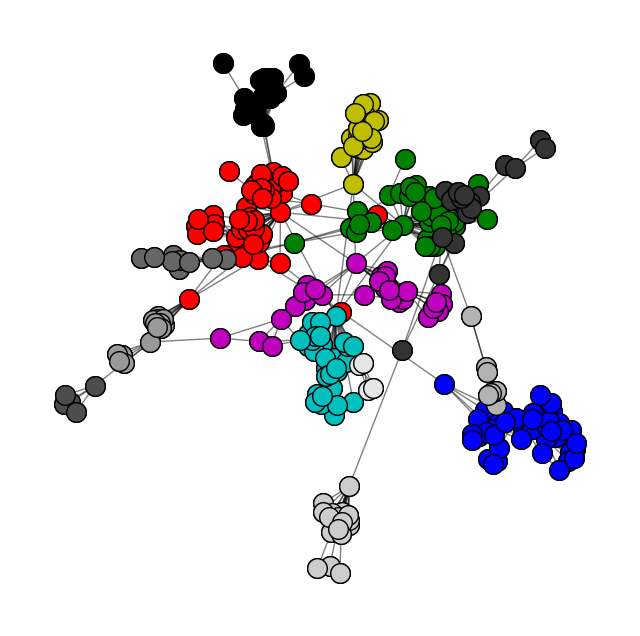

In [36]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_gm, pos)

### 9.j.2. Plot the Community Graph

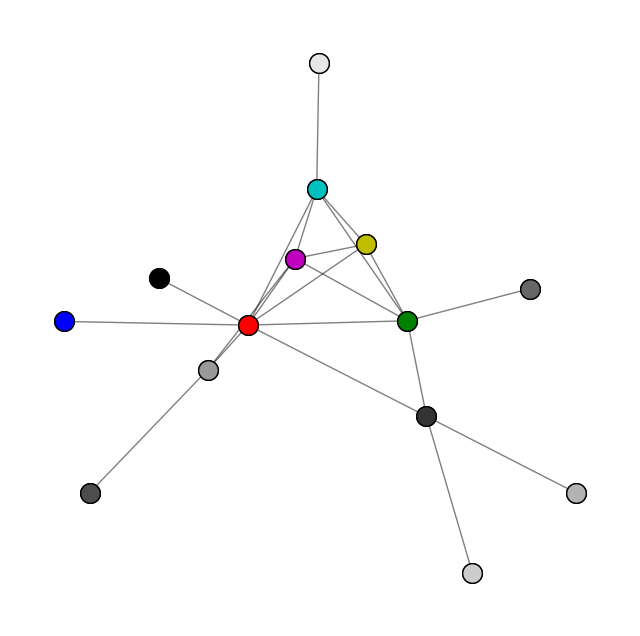

In [37]:
viz.plot_community_graph(g, coms_gm)

### 9.j.3. Evaluate the Modularity

In [38]:
algorithm = "greedy modularity"
m1 = evaluation.erdos_renyi_modularity(g, coms_gm)
m2 = evaluation.link_modularity(g, coms_gm)
m3 = evaluation.modularity_density(g, coms_gm)
m4 = evaluation.newman_girvan_modularity(g, coms_gm)
m5 = evaluation.z_modularity(g, coms_gm)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.8740507379996182
0.10717625189015946
106.1353735577178
0.867665647205193
2.844998987043929


### 9.k.1. Using KCut as Community Algorithm - Network Cluster

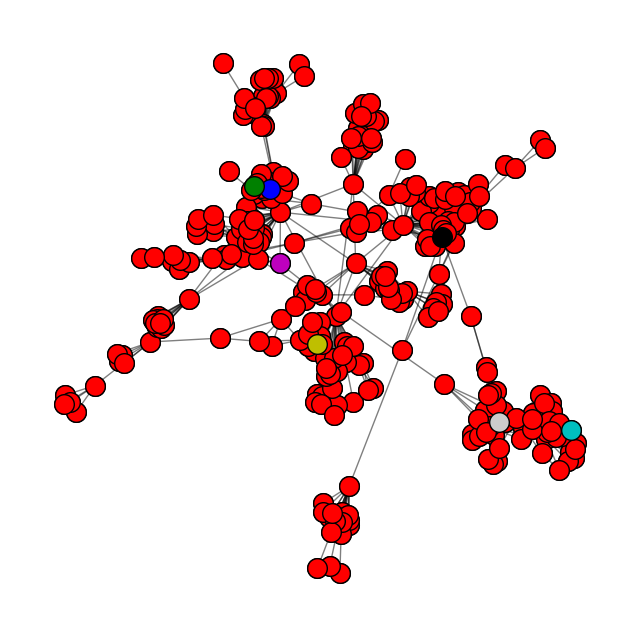

In [39]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_kc, pos)

### 9.k.2. Plot the Community Graph

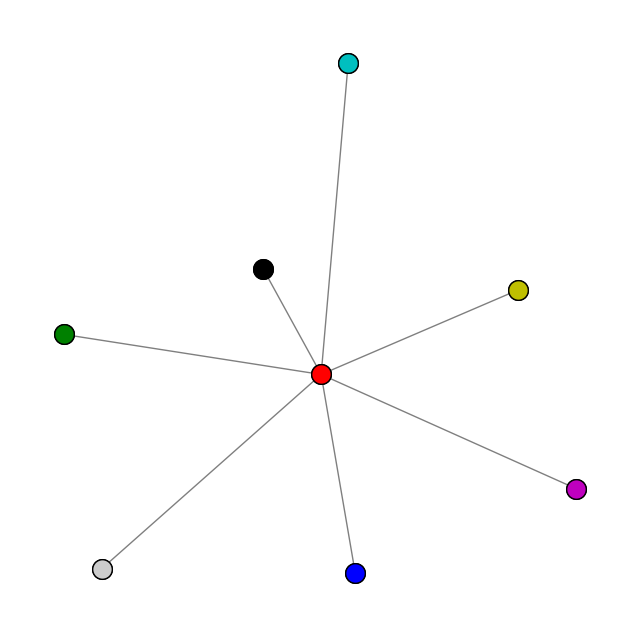

In [40]:
viz.plot_community_graph(g, coms_kc)

### 9.k.3. Evaluate the Modularity

In [41]:
algorithm = "kcut"
m1 = evaluation.erdos_renyi_modularity(g, coms_kc)
m2 = evaluation.link_modularity(g, coms_kc)
m3 = evaluation.modularity_density(g, coms_kc)
m4 = evaluation.newman_girvan_modularity(g, coms_kc)
m5 = evaluation.z_modularity(g, coms_kc)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.006537260801252529
0.1060398917221151
-28.66139240506329
0.00935856462269985
0.04478497157361195


### 9.l.1. Using Label Propagation as Community Algorithm - Network Cluster

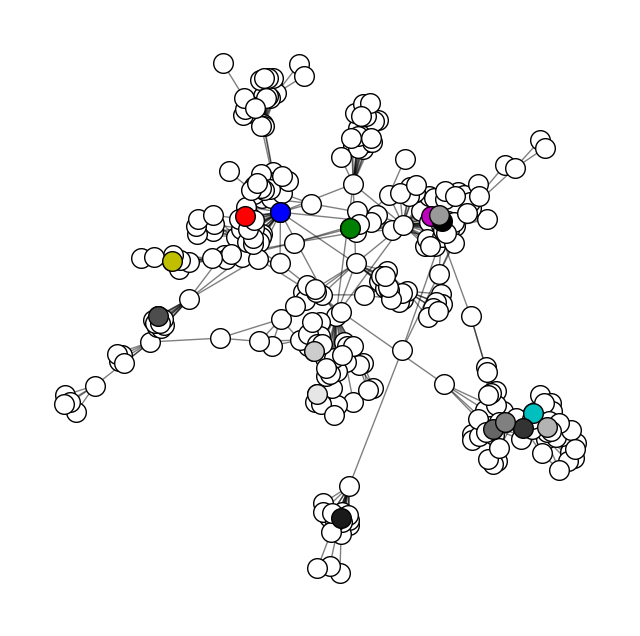

In [42]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_lp, pos)

### 9.l.2. Plot the Community Graph

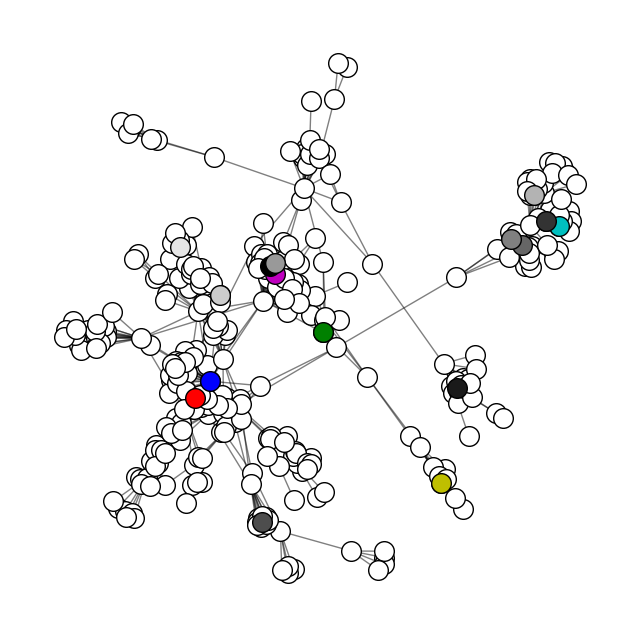

In [43]:
viz.plot_community_graph(g, coms_lp)

### 9.l.3. Evaluate the Modularity

In [44]:
algorithm = "label propagation"
m1 = evaluation.erdos_renyi_modularity(g, coms_lp)
m2 = evaluation.link_modularity(g, coms_lp)
m3 = evaluation.modularity_density(g, coms_lp)
m4 = evaluation.newman_girvan_modularity(g, coms_lp)
m5 = evaluation.z_modularity(g, coms_lp)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.2305496074232691
0.0
-1510.0
0.2261862002311999
3.4316485879321283


### 9.m.1. Using Leiden as Community Algorithm - Network Cluster

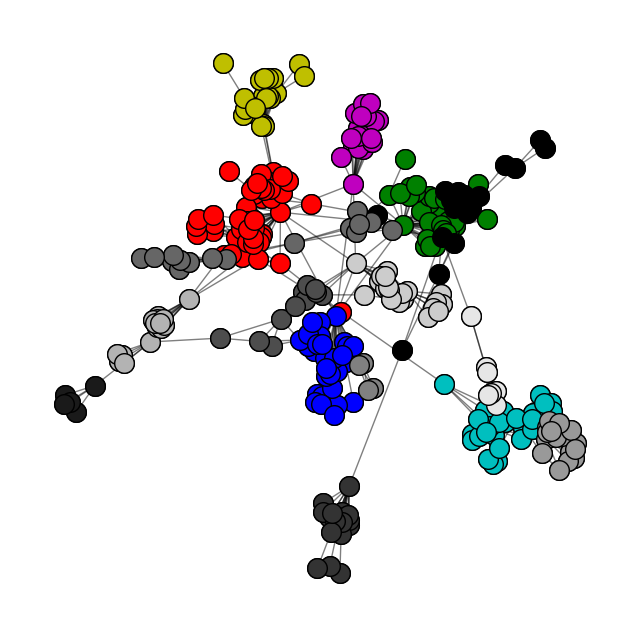

In [45]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_lei, pos)

### 9.m.2. Plot the Community Graph

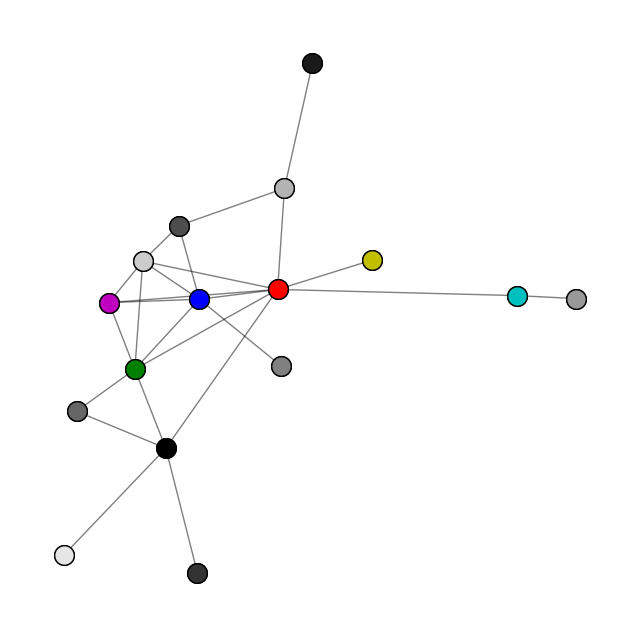

In [46]:
viz.plot_community_graph(g, coms_lei)

### 9.m.3. Evaluate the Modularity

In [47]:
algorithm = "leiden"
m1 = evaluation.erdos_renyi_modularity(g, coms_lei)
m2 = evaluation.link_modularity(g, coms_lei)
m3 = evaluation.modularity_density(g, coms_lei)
m4 = evaluation.newman_girvan_modularity(g, coms_lei)
m5 = evaluation.z_modularity(g, coms_lei)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.8853734526900885
0.1061438357413306
120.10330344258915
0.8774598138069016
3.1157895193227323


### 9.n.1. Using Louvain as Community Algorithm - Network Cluster

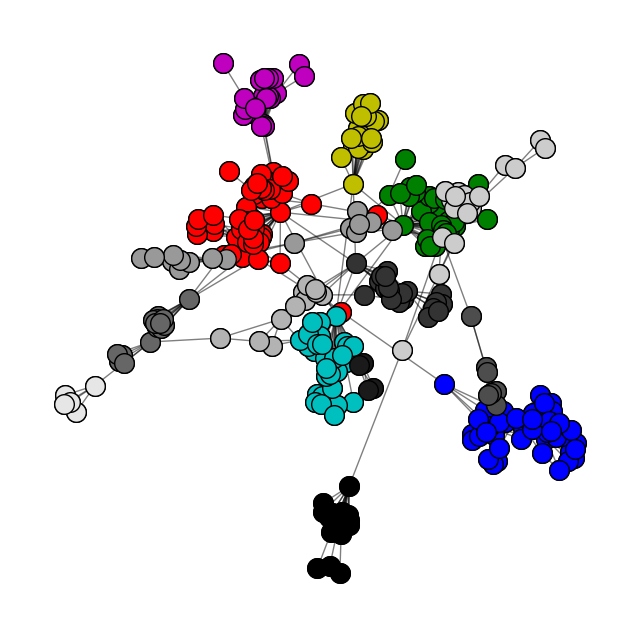

In [48]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_lou, pos)

### 9.n.2. Plot the Community Graph

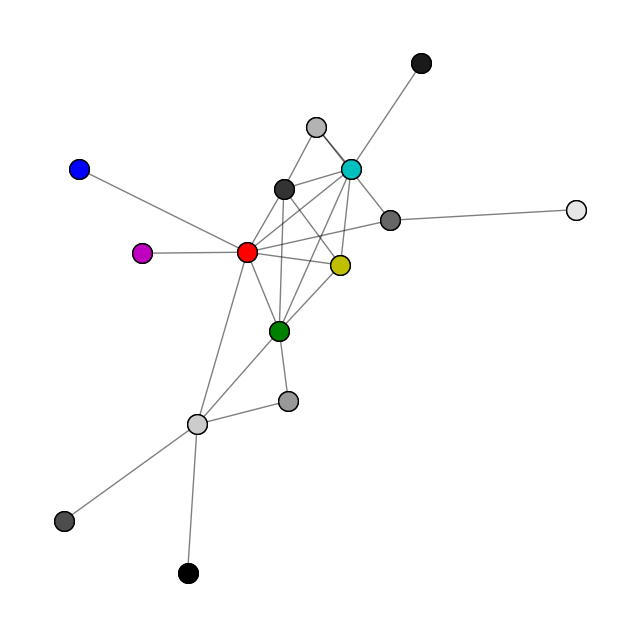

In [49]:
viz.plot_community_graph(g, coms_lou)

### 9.n.3. Evaluate the Modularity

In [50]:
algorithm = "louvain"
m1 = evaluation.erdos_renyi_modularity(g, coms_lou)
m2 = evaluation.link_modularity(g, coms_lou)
m3 = evaluation.modularity_density(g, coms_lou)
m4 = evaluation.newman_girvan_modularity(g, coms_lou)
m5 = evaluation.z_modularity(g, coms_lou)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.8833217124971499
0.1072795346471532
113.31650072150072
0.8756741004309659
2.9657709212848378


### 9.o.1. Using Markov Clustering as Community Algorithm - Network Cluster

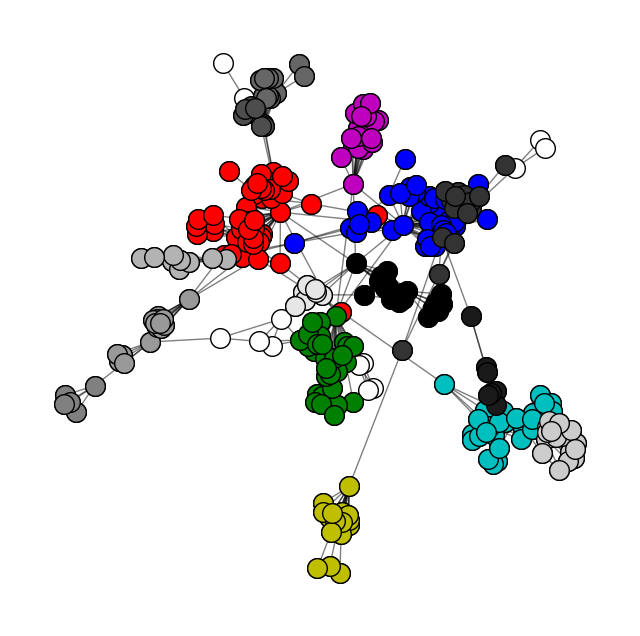

In [51]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_mc, pos)

### 9.o.2. Plot the Community Graph

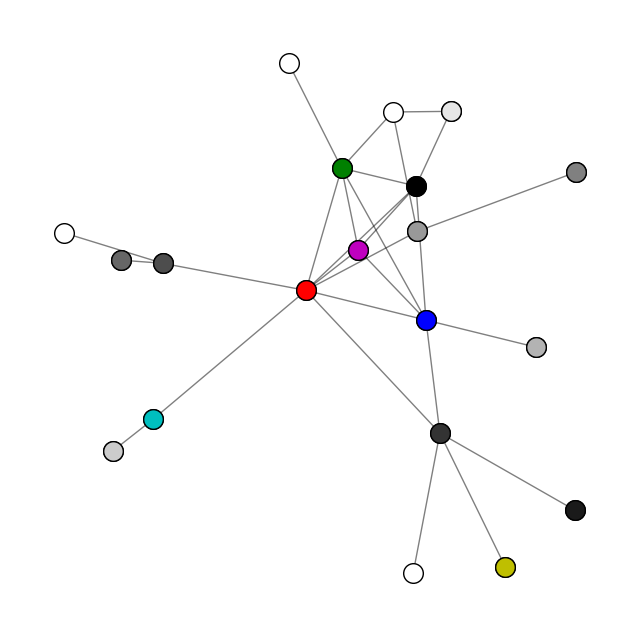

In [52]:
viz.plot_community_graph(g, coms_mc)

### 9.o.3. Evaluate the Modularity

In [53]:
algorithm = "markov clustering"
m1 = evaluation.erdos_renyi_modularity(g, coms_mc)
m2 = evaluation.link_modularity(g, coms_mc)
m3 = evaluation.modularity_density(g, coms_mc)
m4 = evaluation.newman_girvan_modularity(g, coms_mc)
m5 = evaluation.z_modularity(g, coms_mc)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.872157844953847
0.1041820295576221
129.98508785332314
0.8642687159829243
3.0748945072810585


### 9.p.1. Using RBer Pots as Community Algorithm - Network Cluster

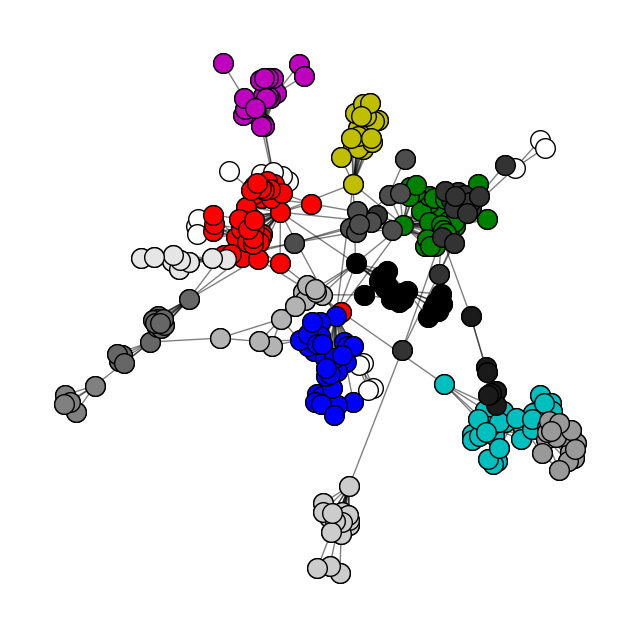

In [54]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_rber, pos)

### 9.p.2. Plot the Community Graph

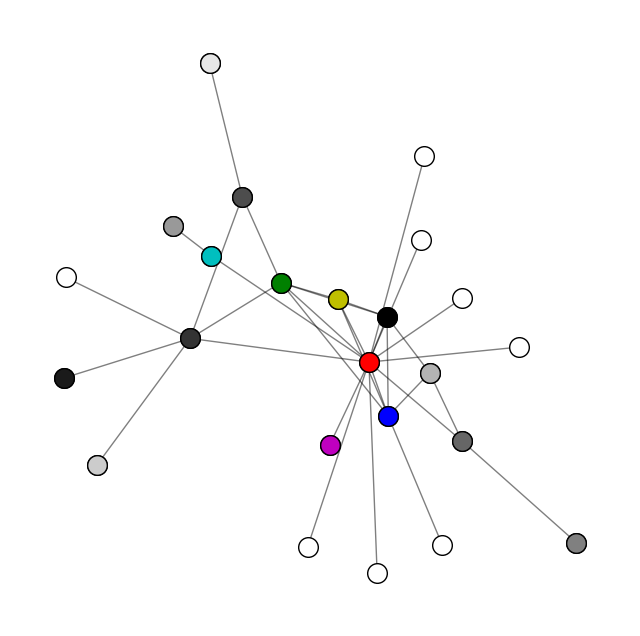

In [55]:
viz.plot_community_graph(g, coms_rber)

### 9.p.3. Evaluate the Modularity

In [56]:
algorithm = "rber pots"
m1 = evaluation.erdos_renyi_modularity(g, coms_rber)
m2 = evaluation.link_modularity(g, coms_rber)
m3 = evaluation.modularity_density(g, coms_rber)
m4 = evaluation.newman_girvan_modularity(g, coms_rber)
m5 = evaluation.z_modularity(g, coms_rber)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.8871921585043346
0.1049048597281529
136.7763294970612
0.8737806328812753
3.1853557233649563


### 9.q.1. Using RB Pots as Community Algorithm - Network Cluster

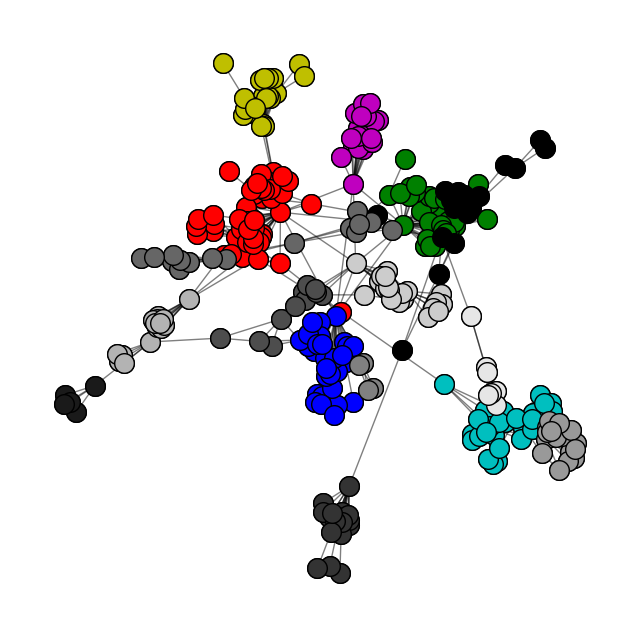

In [57]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_rbp, pos)

### 9.q.2. Plot the Community Graph

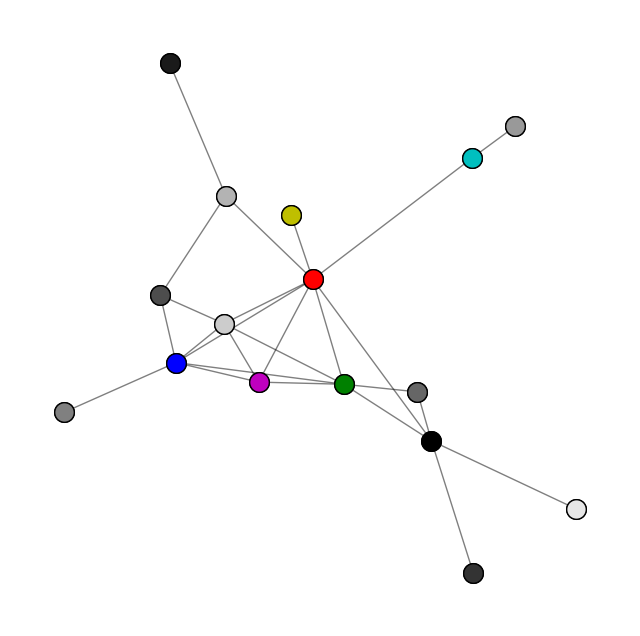

In [58]:
viz.plot_community_graph(g, coms_rbp)

### 9.q.3. Evaluate the Modularity

In [59]:
algorithm = "rb pots"
m1 = evaluation.erdos_renyi_modularity(g, coms_rbp)
m2 = evaluation.link_modularity(g, coms_rbp)
m3 = evaluation.modularity_density(g, coms_rbp)
m4 = evaluation.newman_girvan_modularity(g, coms_rbp)
m5 = evaluation.z_modularity(g, coms_rbp)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.8853734526900885
0.1061438357413306
120.10330344258915
0.8774598138069016
3.1157895193227323


### 9.r.1. Using Significance Communities as Community Algorithm - Network Cluster

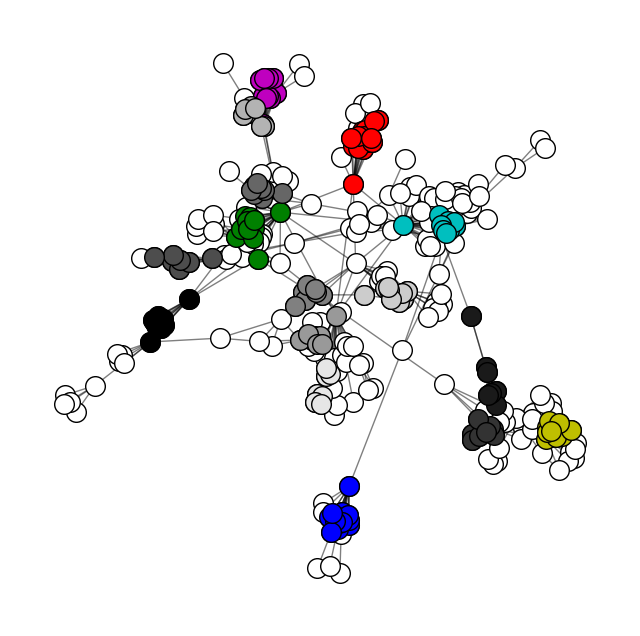

In [60]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_sic, pos)

### 9.r.2. Plot the Community Graph

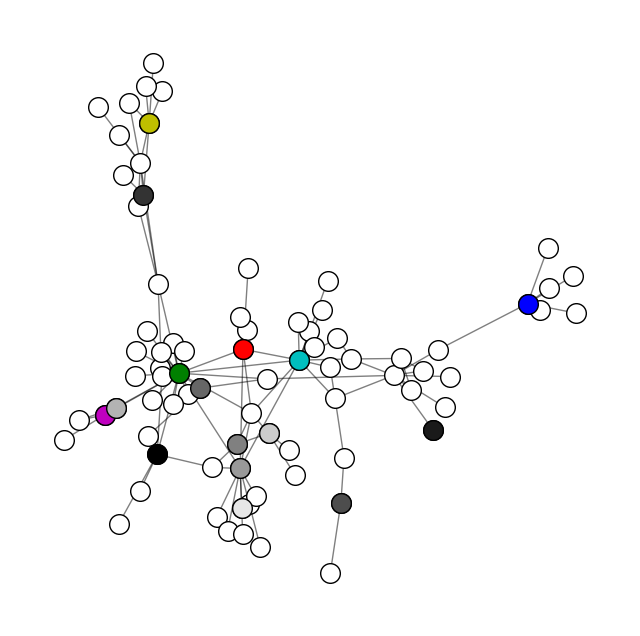

In [61]:
viz.plot_community_graph(g, coms_sic)

### 9.r.3. Evaluate the Modularity

In [62]:
algorithm = "significance communities"
m1 = evaluation.erdos_renyi_modularity(g, coms_sic)
m2 = evaluation.link_modularity(g, coms_sic)
m3 = evaluation.modularity_density(g, coms_sic)
m4 = evaluation.newman_girvan_modularity(g, coms_sic)
m5 = evaluation.z_modularity(g, coms_sic)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.7329894065437368
0.07527173235426114
187.29192751692756
0.7152584495320717
3.8584343201042794


### 9.s.1. Using Spinglass as Community Algorithm - Network Cluster

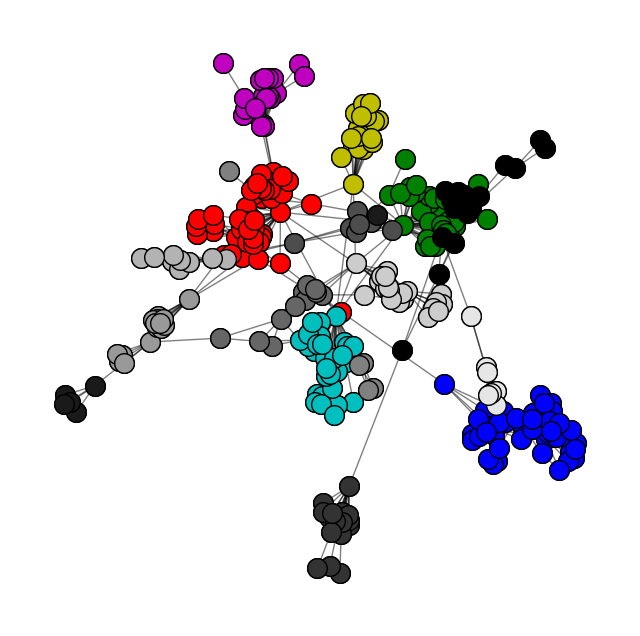

In [63]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_sg, pos)

### 9.s.2. Plot the Community Graph

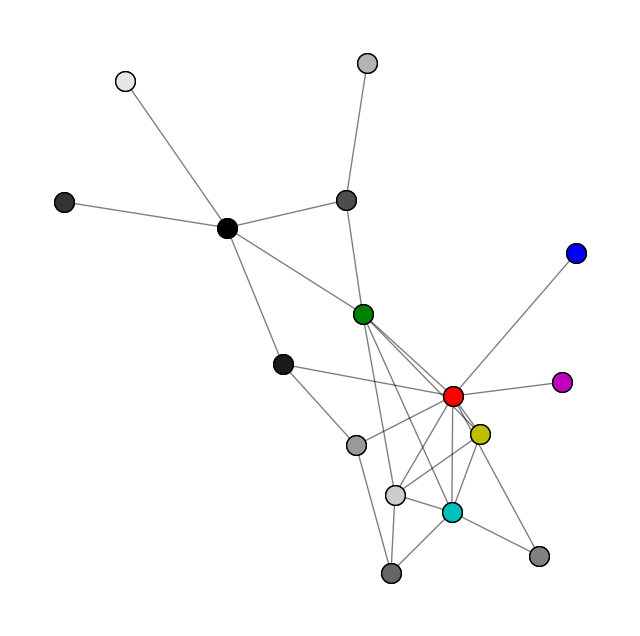

In [64]:
viz.plot_community_graph(g, coms_sg)

### 9.s.3. Evaluate the Modularity

In [65]:
algorithm = "spinglass"
m1 = evaluation.erdos_renyi_modularity(g, coms_sg)
m2 = evaluation.link_modularity(g, coms_sg)
m3 = evaluation.modularity_density(g, coms_sg)
m4 = evaluation.newman_girvan_modularity(g, coms_sg)
m5 = evaluation.z_modularity(g, coms_sg)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.8833702876335731
0.10686652246582395
117.1133658008658
0.8743558312839663
2.982639346857306


### 9.t.1. Using Surprise Communities as Community Algorithm - Network Cluster

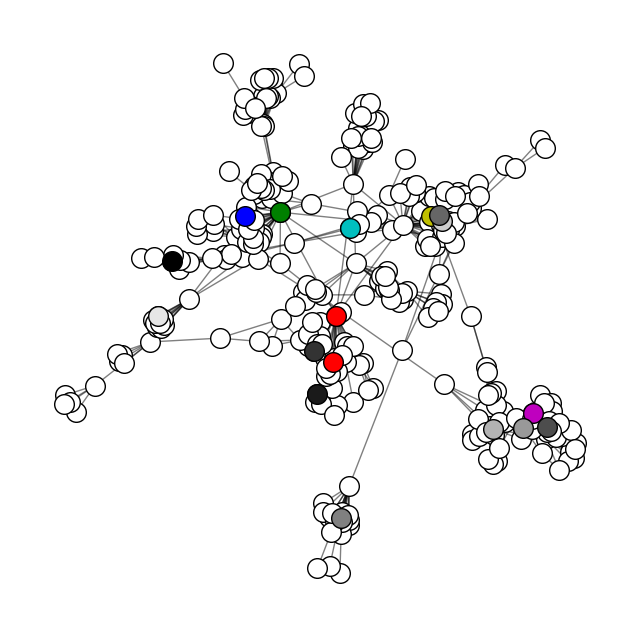

In [66]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_sc, pos)

### 9.t.2. Plot the Community Graph

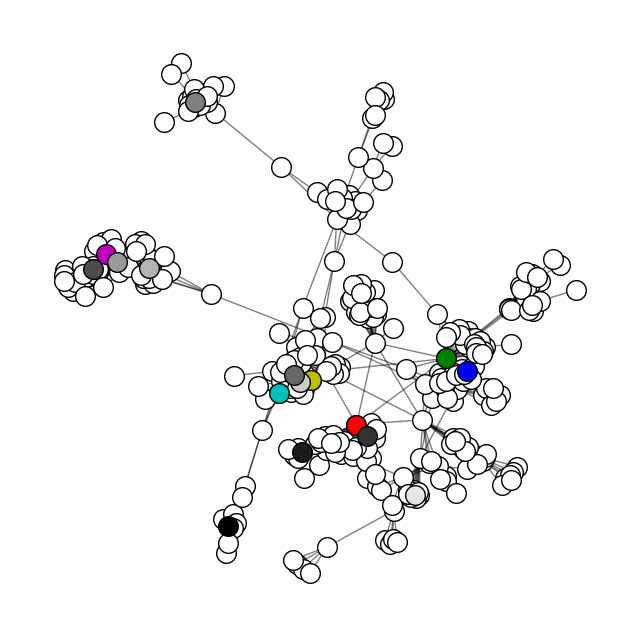

In [67]:
viz.plot_community_graph(g, coms_sc)

### 9.t.3. Evaluate the Modularity

In [68]:
algorithm = "surprise communities"
m1 = evaluation.erdos_renyi_modularity(g, coms_sc)
m2 = evaluation.link_modularity(g, coms_sc)
m3 = evaluation.modularity_density(g, coms_sc)
m4 = evaluation.newman_girvan_modularity(g, coms_sc)
m5 = evaluation.z_modularity(g, coms_sc)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.2312441536378172
0.00010325407254872008
-1491.5
0.2268266115617423
3.4129194522793767


### 9.u.1. Using Walktrap as Community Algorithm - Network Cluster

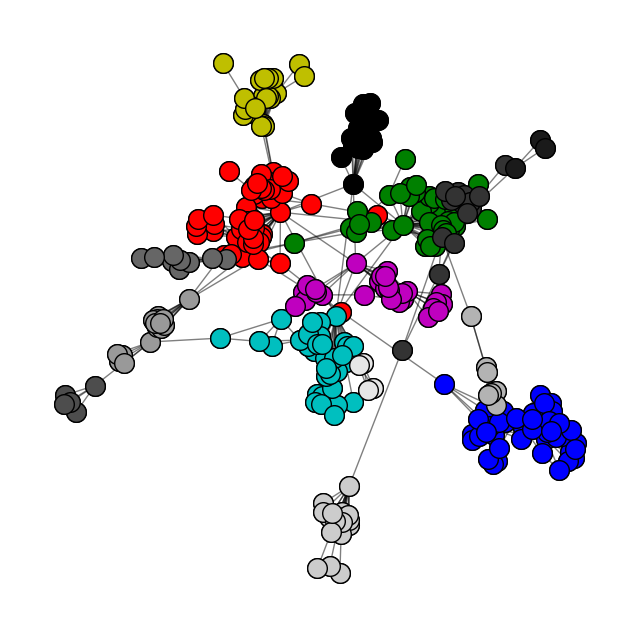

In [69]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_wt, pos)

### 9.u.2. Plot the Community Graph

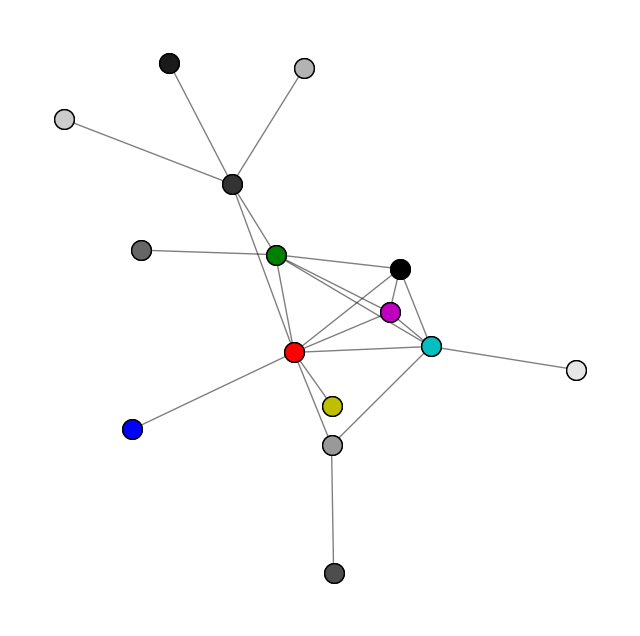

In [70]:
viz.plot_community_graph(g, coms_wt)

### 9.u.3. Evaluate the Modularity

In [71]:
algorithm = "walktrap"
m1 = evaluation.erdos_renyi_modularity(g, coms_wt)
m2 = evaluation.link_modularity(g, coms_wt)
m3 = evaluation.modularity_density(g, coms_wt)
m4 = evaluation.newman_girvan_modularity(g, coms_wt)
m5 = evaluation.z_modularity(g, coms_wt)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.8794871728355098
0.10779577486964902
110.76993752859605
0.8729458564571754
2.874569055630773


### 10. Get the Result of Each Algorithm Modularity Score

In [72]:
eval_table

Algorithm  Erdos Renyi Mod.  Link Mod.  Mod. Density  \
0               async fluid          0.738452   0.107589     55.295618   
0                    belief          0.815622   0.106763     57.221788   
0                       cpm          0.230550   0.000000  -1510.000000   
0          chinese whispers          0.230550   0.000000  -1510.000000   
0                       der          0.456669   0.107073     16.561654   
0               eigenvector          0.839782   0.096645    122.028635   
0                        em          0.829270   0.103046     76.961089   
0                        ga          0.632748   0.061436     53.659921   
0             girvan newman          0.784827   0.109861     54.136951   
0         greedy modularity          0.874051   0.107176    106.135374   
0                      kcut          0.006537   0.106040    -28.661392   
0         label propagation          0.230550   0.000000  -1510.000000   
0                    leiden          0.885373   0.106144    120.103303   
0                   louvain          0.883322   0.107280    113.316501   
0         markov clustering          0.872158   0.104182    129.985088   
0                 rber pots          0.887192   0.104905    136.776329   
0                   rb pots          0.885373   0.106144    120.103303   
0  significance communities          0.732989   0.075272    187.291928   
0                 spinglass          0.883370   0.106867    117.113366   
0      surprise communities          0.231244   0.000103  -1491.500000   
0                  walktrap          0.879487   0.107796    110.769938   

   Newman Girvan Mod.    Z Mod.  
0            0.736531  1.730084  
0            0.810563  2.222122  
0            0.226186  3.431649  
0            0.226186  3.431649  
0            0.466297  0.932630  
0            0.829165  3.261007  
0            0.826836  2.581452  
0            0.617751  3.251806  
0            0.789135  1.969624  
0            0.867666  2.844999  
0            0.009359  0.044785  
0            0.226186  3.431649  
0            0.877460  3.115790  
0            0.875674  2.965771  
0            0.864269  3.074895  
0            0.873781  3.185356  
0            0.877460  3.115790  
0            0.715258  3.858434  
0            0.874356  2.982639  
0            0.226827  3.412919  
0            0.872946  2.874569

### 11. Standardize data, PCA them

In [73]:
df = eval_table.iloc[:, 1:6]

scaler = StandardScaler()
df = scaler.fit_transform(df)
pca = PCA(n_components=1, random_state=0, svd_solver='randomized')
model = pca.fit(df)
df = model.transform(df)
print(df)

[[-0.87709637]
 [-1.10120159]
 [ 3.56499245]
 [ 3.56499245]
 [ 0.07366659]
 [-1.03933512]
 [-1.10154293]
 [ 0.16946916]
 [-1.06104573]
 [-1.30718454]
 [ 1.65096543]
 [ 3.56499245]
 [-1.32540559]
 [-1.33658352]
 [-1.26628535]
 [-1.31613605]
 [-1.32540559]
 [-0.41064391]
 [-1.33135462]
 [ 3.54531596]
 [-1.33517357]]


### 12. Get the Eigenvector

In [74]:
print(pca.components_)

[[-0.49592747 -0.49704855 -0.5059076  -0.4976898   0.05797453]]


### 13. Get the Eigenvalue

In [75]:
print(pca.explained_variance_)

[3.64630446]


### 14. Get the Top 5 Algorithms

In [76]:
eval_table_after_pca = pd.DataFrame(df)
eval_table_after_pca = eval_table.iloc[:, 0].reset_index().join(eval_table_after_pca).drop(columns=['index'])
eval_table_after_pca.sort_values(by=0, ascending=True)

Algorithm         0
13                   louvain -1.336584
20                  walktrap -1.335174
18                 spinglass -1.331355
16                   rb pots -1.325406
12                    leiden -1.325406
15                 rber pots -1.316136
9          greedy modularity -1.307185
14         markov clustering -1.266285
6                         em -1.101543
1                     belief -1.101202
8              girvan newman -1.061046
5                eigenvector -1.039335
0                async fluid -0.877096
17  significance communities -0.410644
4                        der  0.073667
7                         ga  0.169469
10                      kcut  1.650965
19      surprise communities  3.545316
3           chinese whispers  3.564992
2                        cpm  3.564992
11         label propagation  3.564992

### 15.a. Centrality, Size, Edges Count, and Average Degree for Walktrap Algorithm

In [77]:
wt_com = pd.read_csv('walktrap-communities.csv', header=None)
wt_size = []
wt_edges = []
wt_sd = []

for i in range(len(wt_com)):
    doid_list = []
    doid_sign = []
    for j in wt_com.iloc[i]:
        if str(j) != 'nan':
            doid_list.append(j)
    k = copy.deepcopy(df_wang)
    doid_col_nums = []
    for doid in doid_list:
        doid_col_nums.append(k.columns.get_loc(doid))
    community_adj_mat = k[doid_list].iloc[doid_col_nums]
    com_graph = nx.from_numpy_matrix(community_adj_mat.values)
    com_graph = nx.relabel_nodes(com_graph, dict(enumerate(community_adj_mat.columns)))
    
    wt_size.append(("Walktrap", com_graph.number_of_nodes()))
    wt_edges.append(("Walktrap", com_graph.number_of_edges()))
    wt_sd.append(("Walktrap", nx.density(com_graph)/overall_density))
    
    bc = nx.betweenness_centrality(com_graph)
    dc = nx.degree_centrality(com_graph)
    cc = nx.closeness_centrality(com_graph)
    ev = nx.eigenvector_centrality(com_graph, 1000)

    print(i+1)
    max_keys_bc = [key for key, value in bc.items() if value == max(bc.values())]
    print(max_keys_bc)
    max_keys_dc = [key for key, value in dc.items() if value == max(dc.values())]
    print(max_keys_dc)
    max_keys_cc = [key for key, value in cc.items() if value == max(cc.values())]
    print(max_keys_cc)
    max_keys_ev = [key for key, value in ev.items() if value == max(ev.values())]
    print(max_keys_ev)
    print()

1
['DOID.863']
['DOID.863']
['DOID.863']
['DOID.863']

2
['DOID.150']
['DOID.150']
['DOID.150']
['DOID.0060037']

3
['DOID.77']
['DOID.77']
['DOID.77']
['DOID.77']

4
['DOID.1287']
['DOID.1287']
['DOID.1287']
['DOID.1287']

5
['DOID.0080001']
['DOID.0080001']
['DOID.0080001']
['DOID.0080001']

6
['DOID.8466']
['DOID.8466']
['DOID.790', 'DOID.8466', 'DOID.9335', 'DOID.0060260']
['DOID.8466']

7
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']

8
['DOID.2723']
['DOID.2723']
['DOID.2723']
['DOID.2723']

9
['DOID.417']
['DOID.417']
['DOID.417']
['DOID.417']

10
['DOID.0050736']
['DOID.0050736']
['DOID.0050736']
['DOID.0050736']

11
['DOID.557']
['DOID.557']
['DOID.557']
['DOID.557']

12
['DOID.50']
['DOID.50']
['DOID.50']
['DOID.50']

13
['DOID.630']
['DOID.630']
['DOID.630']
['DOID.630']

14
['DOID.13098', 'DOID.1727', 'DOID.8483', 'DOID.13094']
['DOID.13098', 'DOID.1727', 'DOID.8483', 'DOID.13094']
['DOID.13098', 'DOID.17

Summary:

```
1.  DOID.863     -> nervous system disease
2.  DOID.150     -> disease of mental health
3.  DOID.77      -> gastrointestinal system disease
4.  DOID.1287    -> cardiovascular system disease
5.  DOID.0080001 -> bone disease
6.  DOID.8466    -> retinal degeneration
7.  DOID.850     -> lung disease
7.  DOID.0050161 -> lower respiratory tract disease
8.  DOID.2723    -> dermatitis
9.  DOID.417     -> autoimmune disease
10. DOID.0050736 -> autosomal dominant disease
11. DOID.557     -> kidney disease
12. DOID.50      -> thyroid gland disease
13. DOID.630     -> genetic disease
14. DOID.8483    -> retinal artery occlusion
14. DOID.1727    -> retinal vein occlusion
14. DOID.13098   -> central retinal artery occlusion
14. DOID.13094   -> branch retinal artery occlusion
15. DOID.612     -> primary immunodeficiency disease
```

### 15.b. Centrality, Size, Edges Count, and Average Degree for Leiden Algorithm

In [78]:
lei_com = pd.read_csv('leiden-communities.csv', header=None)
lei_size = []
lei_edges = []
lei_sd = []

for i in range(len(lei_com)):
    doid_list = []
    doid_sign = []
    for j in lei_com.iloc[i]:
        if str(j) != 'nan':
            doid_list.append(j)
    k = copy.deepcopy(df_wang)
    doid_col_nums = []
    for doid in doid_list:
        doid_col_nums.append(k.columns.get_loc(doid))
    community_adj_mat = k[doid_list].iloc[doid_col_nums]
    com_graph = nx.from_numpy_matrix(community_adj_mat.values)
    com_graph = nx.relabel_nodes(com_graph, dict(enumerate(community_adj_mat.columns)))
    
    lei_size.append(("Leiden", com_graph.number_of_nodes()))
    lei_edges.append(("Leiden", com_graph.number_of_edges()))
    lei_sd.append(("Leiden", nx.density(com_graph)/overall_density))
    
    bc = nx.betweenness_centrality(com_graph)
    dc = nx.degree_centrality(com_graph)
    cc = nx.closeness_centrality(com_graph)
    ev = nx.eigenvector_centrality(com_graph, 1000)
    
    print(i+1)
    max_keys_bc = [key for key, value in bc.items() if value == max(bc.values())]
    print(max_keys_bc)
    max_keys_dc = [key for key, value in dc.items() if value == max(dc.values())]
    print(max_keys_dc)
    max_keys_cc = [key for key, value in cc.items() if value == max(cc.values())]
    print(max_keys_cc)
    max_keys_ev = [key for key, value in ev.items() if value == max(ev.values())]
    print(max_keys_ev)
    print()

1
['DOID.863']
['DOID.863']
['DOID.863']
['DOID.863']

2
['DOID.1287']
['DOID.1287']
['DOID.1287']
['DOID.1287']

3
['DOID.77']
['DOID.77']
['DOID.77']
['DOID.77']

4
['DOID.150']
['DOID.1561', 'DOID.150']
['DOID.1561', 'DOID.150']
['DOID.1561']

5
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']

6
['DOID.8466']
['DOID.8466']
['DOID.790', 'DOID.8466', 'DOID.9335', 'DOID.0060260']
['DOID.8466']

7
['DOID.0060056']
['DOID.417']
['DOID.417', 'DOID.0060056']
['DOID.417']

8
['DOID.0080001']
['DOID.0080001']
['DOID.0080001']
['DOID.0080001']

9
['DOID.2723']
['DOID.2723']
['DOID.2723']
['DOID.2723']

10
['DOID.0060037']
['DOID.0060037']
['DOID.0060037']
['DOID.0060037']

11
['DOID.11823']
['DOID.557']
['DOID.3021']
['DOID.557']

12
['DOID.0050736']
['DOID.0050736']
['DOID.0050736']
['DOID.0050736']

13
['DOID.0050700']
['DOID.633']
['DOID.633']
['DOID.633']

14
['DOID.50']
['DOID.50']
['DOID.50']
['DOID.50']

15
['DOID.630'

Summary:

```
1.  DOID.863     -> nervous system disease
2.  DOID.77      -> gastrointestinal system disease
3.  DOID.1287    -> cardiovascular system disease
4.  DOID.150     -> disease of mental health
4.  DOID.1561    -> cognitive disorder
5.  DOID.8466    -> retinal degeneration
6.  DOID.850     -> lung disease
6.  DOID.0050161 -> lower respiratory tract disease
7.  DOID.417     -> autoimmune disease
8.  DOID.0080001 -> bone disease
9.  DOID.2723    -> dermatitis
10. DOID.0060037 -> developmental disorder of mental health
11. DOID.557     -> kidney disease
12. DOID.0050736 -> autosomal dominant disease
13. DOID.633     -> myositis
14. DOID.50      -> thyroid gland disease
15. DOID.630     -> genetic disease
16. DOID.8483    -> retinal artery occlusion
16. DOID.1727    -> retinal vein occlusion
16. DOID.13098   -> central retinal artery occlusion
16. DOID.13094   -> branch retinal artery occlusion
```

### 15.c. Centrality, Size, Edges Count, and Average Degree for Louvain Algorithm

In [79]:
lou_com = pd.read_csv('louvain-communities.csv', header=None)
lou_size = []
lou_edges = []
lou_sd = []

for i in range(len(lou_com)):
    doid_list = []
    doid_sign = []
    for j in lou_com.iloc[i]:
        if str(j) != 'nan':
            doid_list.append(j)
    k = copy.deepcopy(df_wang)
    doid_col_nums = []
    for doid in doid_list:
        doid_col_nums.append(k.columns.get_loc(doid))
    community_adj_mat = k[doid_list].iloc[doid_col_nums]
    com_graph = nx.from_numpy_matrix(community_adj_mat.values)
    com_graph = nx.relabel_nodes(com_graph, dict(enumerate(community_adj_mat.columns)))
    
    lou_size.append(("Louvain", com_graph.number_of_nodes()))
    lou_edges.append(("Louvain", com_graph.number_of_edges()))
    lou_sd.append(("Louvain", nx.density(com_graph)/overall_density))
    
    bc = nx.betweenness_centrality(com_graph)
    dc = nx.degree_centrality(com_graph)
    cc = nx.closeness_centrality(com_graph)
    ev = nx.eigenvector_centrality(com_graph, 1000)

    print(i+1)
    max_keys_bc = [key for key, value in bc.items() if value == max(bc.values())]
    print(max_keys_bc)
    max_keys_dc = [key for key, value in dc.items() if value == max(dc.values())]
    print(max_keys_dc)
    max_keys_cc = [key for key, value in cc.items() if value == max(cc.values())]
    print(max_keys_cc)
    max_keys_ev = [key for key, value in ev.items() if value == max(ev.values())]
    print(max_keys_ev)
    print()

1
['DOID.863']
['DOID.863']
['DOID.863']
['DOID.863']

2
['DOID.150']
['DOID.150']
['DOID.150']
['DOID.0060037']

3
['DOID.77']
['DOID.77']
['DOID.77']
['DOID.77']

4
['DOID.1287']
['DOID.1287']
['DOID.1287']
['DOID.1287']

5
['DOID.8466']
['DOID.8466']
['DOID.790', 'DOID.8466', 'DOID.9335', 'DOID.0060260']
['DOID.8466']

6
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']

7
['DOID.2723']
['DOID.2723']
['DOID.2723']
['DOID.2723']

8
['DOID.0060056']
['DOID.417']
['DOID.0060056']
['DOID.417']

9
['DOID.0080001']
['DOID.0080001']
['DOID.0080001']
['DOID.0080001']

10
['DOID.11823']
['DOID.557']
['DOID.3021']
['DOID.557']

11
['DOID.0050736']
['DOID.0050736']
['DOID.0050736']
['DOID.0050736']

12
['DOID.0050700']
['DOID.633']
['DOID.633']
['DOID.633']

13
['DOID.50']
['DOID.50']
['DOID.50']
['DOID.50']

14
['DOID.630']
['DOID.630']
['DOID.630']
['DOID.630']

15
['DOID.13098', 'DOID.1727', 'DOID.8483', 'DOID.13094']
['DOID.

Summary:

```
1.  DOID.863     -> nervous system disease
2.  DOID.77      -> gastrointestinal system disease
3.  DOID.1287    -> cardiovascular system disease
4.  DOID.150     -> disease of mental health
4.  DOID.1561    -> cognitive disorder
5.  DOID.0060056 -> hypersensitivity reaction disease
5.  DOID.417     -> autoimmune disease
6.  DOID.8466    -> retinal degeneration
7.  DOID.850     -> lung disease
7.  DOID.0050161 -> lower respiratory tract disease
8.  DOID.0080001 -> bone disease
9.  DOID.2723    -> dermatitis
10. DOID.0060037 -> developmental disorder of mental health
11. DOID.0050736 -> autosomal dominant disease
12. DOID.633     -> myositis
13. DOID.557     -> kidney disease
14. DOID.50      -> thyroid gland disease
15. DOID.630     -> genetic disease
16. DOID.8483    -> retinal artery occlusion
16. DOID.1727    -> retinal vein occlusion
16. DOID.13098   -> central retinal artery occlusion
16. DOID.13094   -> branch retinal artery occlusion
```

### 15.d. Centrality, Size, Edges Count, and Average Degree for RB Pots Algorithm

In [80]:
rbp_com = pd.read_csv('rbpots-communities.csv', header=None)
rbp_size = []
rbp_edges = []
rbp_sd = []

for i in range(len(rbp_com)):
    doid_list = []
    doid_sign = []
    for j in rbp_com.iloc[i]:
        if str(j) != 'nan':
            doid_list.append(j)
    k = copy.deepcopy(df_wang)
    doid_col_nums = []
    for doid in doid_list:
        doid_col_nums.append(k.columns.get_loc(doid))
    community_adj_mat = k[doid_list].iloc[doid_col_nums]
    com_graph = nx.from_numpy_matrix(community_adj_mat.values)
    com_graph = nx.relabel_nodes(com_graph, dict(enumerate(community_adj_mat.columns)))
    
    rbp_size.append(("RB Pots", com_graph.number_of_nodes()))
    rbp_edges.append(("RB Pots", com_graph.number_of_edges()))
    rbp_sd.append(("RB Pots", nx.density(com_graph)/overall_density))
    
    bc = nx.betweenness_centrality(com_graph)
    dc = nx.degree_centrality(com_graph)
    cc = nx.closeness_centrality(com_graph)
    ev = nx.eigenvector_centrality(com_graph, 1000)

    print(i+1)
    max_keys_bc = [key for key, value in bc.items() if value == max(bc.values())]
    print(max_keys_bc)
    max_keys_dc = [key for key, value in dc.items() if value == max(dc.values())]
    print(max_keys_dc)
    max_keys_cc = [key for key, value in cc.items() if value == max(cc.values())]
    print(max_keys_cc)
    max_keys_ev = [key for key, value in ev.items() if value == max(ev.values())]
    print(max_keys_ev)
    print()

1
['DOID.863']
['DOID.863']
['DOID.863']
['DOID.863']

2
['DOID.1287']
['DOID.1287']
['DOID.1287']
['DOID.1287']

3
['DOID.77']
['DOID.77']
['DOID.77']
['DOID.77']

4
['DOID.150']
['DOID.1561', 'DOID.150']
['DOID.1561', 'DOID.150']
['DOID.1561']

5
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']

6
['DOID.8466']
['DOID.8466']
['DOID.790', 'DOID.8466', 'DOID.9335', 'DOID.0060260']
['DOID.8466']

7
['DOID.0060056']
['DOID.417']
['DOID.417', 'DOID.0060056']
['DOID.417']

8
['DOID.0080001']
['DOID.0080001']
['DOID.0080001']
['DOID.0080001']

9
['DOID.2723']
['DOID.2723']
['DOID.2723']
['DOID.2723']

10
['DOID.0060037']
['DOID.0060037']
['DOID.0060037']
['DOID.0060037']

11
['DOID.11823']
['DOID.557']
['DOID.3021']
['DOID.557']

12
['DOID.0050736']
['DOID.0050736']
['DOID.0050736']
['DOID.0050736']

13
['DOID.0050700']
['DOID.633']
['DOID.633']
['DOID.633']

14
['DOID.50']
['DOID.50']
['DOID.50']
['DOID.50']

15
['DOID.630'

Summary:

```
1.  DOID.863     -> nervous system disease
2.  DOID.77      -> gastrointestinal system disease
3.  DOID.1287    -> cardiovascular system disease
4.  DOID.150     -> disease of mental health
4.  DOID.1561    -> cognitive disorder
5.  DOID.8466    -> retinal degeneration
6.  DOID.850     -> lung disease
6.  DOID.0050161 -> lower respiratory tract disease
7.  DOID.417     -> autoimmune disease
8.  DOID.0080001 -> bone disease
9.  DOID.2723    -> dermatitis
10. DOID.0060037 -> developmental disorder of mental health
11. DOID.557     -> kidney disease
12. DOID.0050736 -> autosomal dominant disease
13. DOID.633     -> myositis
14. DOID.50      -> thyroid gland disease
15. DOID.630     -> genetic disease
16. DOID.8483    -> retinal artery occlusion
16. DOID.1727    -> retinal vein occlusion
16. DOID.13098   -> central retinal artery occlusion
16. DOID.13094   -> branch retinal artery occlusion
```

### 15.e. Centrality, Size, Edges Count, and Average Degree for RBER Pots Algorithm

In [81]:
rber_com = pd.read_csv('rberpots-communities.csv', header=None)
rber_size = []
rber_edges = []
rber_sd = []

for i in range(len(rber_com)):
    doid_list = []
    doid_sign = []
    for j in rber_com.iloc[i]:
        if str(j) != 'nan':
            doid_list.append(j)
    k = copy.deepcopy(df_wang)
    doid_col_nums = []
    for doid in doid_list:
        doid_col_nums.append(k.columns.get_loc(doid))
    community_adj_mat = k[doid_list].iloc[doid_col_nums]
    com_graph = nx.from_numpy_matrix(community_adj_mat.values)
    com_graph = nx.relabel_nodes(com_graph, dict(enumerate(community_adj_mat.columns)))
    
    rber_size.append(("RBer Pots", com_graph.number_of_nodes()))
    rber_edges.append(("RBer Pots", com_graph.number_of_edges()))
    rber_sd.append(("RBer Pots", nx.density(com_graph)/overall_density))
    
    bc = nx.betweenness_centrality(com_graph)
    dc = nx.degree_centrality(com_graph)
    cc = nx.closeness_centrality(com_graph)
    ev = nx.eigenvector_centrality(com_graph, 1000)
    
    print(i+1)
    max_keys_bc = [key for key, value in bc.items() if value == max(bc.values())]
    print(max_keys_bc)
    max_keys_dc = [key for key, value in dc.items() if value == max(dc.values())]
    print(max_keys_dc)
    max_keys_cc = [key for key, value in cc.items() if value == max(cc.values())]
    print(max_keys_cc)
    max_keys_ev = [key for key, value in ev.items() if value == max(ev.values())]
    print(max_keys_ev)
    print()

1
['DOID.863']
['DOID.863']
['DOID.863']
['DOID.863']

2
['DOID.1287']
['DOID.1287']
['DOID.1287']
['DOID.1287']

3
['DOID.77']
['DOID.77']
['DOID.77']
['DOID.77']

4
['DOID.150']
['DOID.1561', 'DOID.150']
['DOID.1561', 'DOID.150']
['DOID.1561']

5
['DOID.8466']
['DOID.8466']
['DOID.790', 'DOID.8466', 'DOID.9335', 'DOID.0060260']
['DOID.8466']

6
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']

7
['DOID.0080001']
['DOID.0080001']
['DOID.0080001']
['DOID.0080001']

8
['DOID.2723']
['DOID.2723']
['DOID.2723']
['DOID.2723']

9
['DOID.417']
['DOID.417']
['DOID.417']
['DOID.417']

10
['DOID.0060037']
['DOID.0060037']
['DOID.0060037']
['DOID.0060037']

11
['DOID.0050736']
['DOID.0050736']
['DOID.0050736']
['DOID.0050736']

12
['DOID.0050700']
['DOID.633']
['DOID.633']
['DOID.633']

13
['DOID.409']
['DOID.409']
['DOID.409']
['DOID.409']

14
['DOID.557']
['DOID.557']
['DOID.557']
['DOID.557']

15
['DOID.50']
['DOID.50']
['DOID

Summary:

```
1.  DOID.863     -> nervous system disease
2.  DOID.1287    -> cardiovascular system disease
3.  DOID.77      -> gastrointestinal system disease
4.  DOID.150     -> disease of mental health
4.  DOID.1561    -> cognitive disorder
5.  DOID.850     -> lung disease
5.  DOID.0050161 -> lower respiratory tract disease
6.  DOID.8466    -> retinal degeneration
7.  DOID.2723    -> dermatitis
8.  DOID.0080001 -> bone disease
9.  DOID.417     -> autoimmune disease
10. DOID.0060037 -> developmental disorder of mental health
11. DOID.0050736 -> autosomal dominant disease
12. DOID.633     -> myositis
13. DOID.409     -> liver disease
14. DOID.557     -> kidney disease
15. DOID.50      -> thyroid gland disease
16. DOID.630     -> genetic disease
17. DOID.8483    -> retinal artery occlusion
17. DOID.1727    -> retinal vein occlusion
17. DOID.13098   -> central retinal artery occlusion
17. DOID.13094   -> branch retinal artery occlusion
18. DOID.612     -> primary immunodeficiency disease
19. DOID.11577   -> cauda equina syndrome
19. DOID.1389    -> polyneuropathy
20. DOID.10588   -> adrenoleukodystrophy
20. DOID.10908   -> hydrocephalus
21. DOID.0050754 -> ataxia with oculomotor apraxia type 1
22. DOID.12506   -> Bell's palsy
23. DOID.7439    -> polyp of middle ear
24. DOID.11486   -> Horner's syndrome
```

In [82]:
bel_com = pd.read_csv('belief-communities.csv', header=None)
bel_size = []
bel_edges = []
bel_sd = []

for i in range(len(bel_com)):
    doid_list = []
    doid_sign = []
    for j in bel_com.iloc[i]:
        if str(j) != 'nan':
            doid_list.append(j)
    k = copy.deepcopy(df_wang)
    doid_col_nums = []
    for doid in doid_list:
        doid_col_nums.append(k.columns.get_loc(doid))
    community_adj_mat = k[doid_list].iloc[doid_col_nums]
    com_graph = nx.from_numpy_matrix(community_adj_mat.values)
    com_graph = nx.relabel_nodes(com_graph, dict(enumerate(community_adj_mat.columns)))
    
    bel_size.append(("Belief", com_graph.number_of_nodes()))
    bel_edges.append(("Belief", com_graph.number_of_edges()))
    bel_sd.append(("Belief", nx.density(com_graph)/overall_density))
    
    bc = nx.betweenness_centrality(com_graph)
    dc = nx.degree_centrality(com_graph)
    cc = nx.closeness_centrality(com_graph)
    ev = nx.eigenvector_centrality(com_graph, 1000)
    
    print(i+1)
    max_keys_bc = [key for key, value in bc.items() if value == max(bc.values())]
    print(max_keys_bc)
    max_keys_dc = [key for key, value in dc.items() if value == max(dc.values())]
    print(max_keys_dc)
    max_keys_cc = [key for key, value in cc.items() if value == max(cc.values())]
    print(max_keys_cc)
    max_keys_ev = [key for key, value in ev.items() if value == max(ev.values())]
    print(max_keys_ev)
    print()

1
['DOID.77']
['DOID.77']
['DOID.77']
['DOID.0050161', 'DOID.850']

2
['DOID.150']
['DOID.150']
['DOID.150']
['DOID.0060037']

3
['DOID.417']
['DOID.1287']
['DOID.1287']
['DOID.1287']

4
['DOID.863']
['DOID.863']
['DOID.863']
['DOID.863']

5
['DOID.17']
['DOID.0080001']
['DOID.17']
['DOID.0080001']

6
['DOID.8466']
['DOID.8466']
['DOID.790', 'DOID.8466', 'DOID.9335', 'DOID.0060260']
['DOID.8466']

7
['DOID.2723']
['DOID.2723']
['DOID.2723']
['DOID.2723']



In [83]:
gn_com = pd.read_csv('girvannewman-communities.csv', header=None)
gn_size = []
gn_edges = []
gn_sd = []

for i in range(len(gn_com)):
    doid_list = []
    doid_sign = []
    for j in gn_com.iloc[i]:
        if str(j) != 'nan':
            doid_list.append(j)
    k = copy.deepcopy(df_wang)
    doid_col_nums = []
    for doid in doid_list:
        doid_col_nums.append(k.columns.get_loc(doid))
    community_adj_mat = k[doid_list].iloc[doid_col_nums]
    com_graph = nx.from_numpy_matrix(community_adj_mat.values)
    com_graph = nx.relabel_nodes(com_graph, dict(enumerate(community_adj_mat.columns)))
    
    gn_size.append(("Girvan Newman", com_graph.number_of_nodes()))
    gn_edges.append(("Girvan Newman", com_graph.number_of_edges()))
    gn_sd.append(("Girvan Newman", nx.density(com_graph)/overall_density))
    
    bc = nx.betweenness_centrality(com_graph)
    dc = nx.degree_centrality(com_graph)
    cc = nx.closeness_centrality(com_graph)
    ev = nx.eigenvector_centrality(com_graph, 1000)
    
    print(i+1)
    max_keys_bc = [key for key, value in bc.items() if value == max(bc.values())]
    print(max_keys_bc)
    max_keys_dc = [key for key, value in dc.items() if value == max(dc.values())]
    print(max_keys_dc)
    max_keys_cc = [key for key, value in cc.items() if value == max(cc.values())]
    print(max_keys_cc)
    max_keys_ev = [key for key, value in ev.items() if value == max(ev.values())]
    print(max_keys_ev)
    print()

1
['DOID.863']
['DOID.863']
['DOID.863']
['DOID.863']

2
['DOID.77']
['DOID.77']
['DOID.409']
['DOID.77']

3
['DOID.1287']
['DOID.1287']
['DOID.1287']
['DOID.1287']

4
['DOID.150']
['DOID.150']
['DOID.150']
['DOID.0060037']

5
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']

6
['DOID.2723']
['DOID.2723']
['DOID.2723']
['DOID.2723']



In [84]:
sg_com = pd.read_csv('spinglass-communities.csv', header=None)
sg_size = []
sg_edges = []
sg_sd = []

for i in range(len(sg_com)):
    doid_list = []
    doid_sign = []
    for j in sg_com.iloc[i]:
        if str(j) != 'nan':
            doid_list.append(j)
    k = copy.deepcopy(df_wang)
    doid_col_nums = []
    for doid in doid_list:
        doid_col_nums.append(k.columns.get_loc(doid))
    community_adj_mat = k[doid_list].iloc[doid_col_nums]
    com_graph = nx.from_numpy_matrix(community_adj_mat.values)
    com_graph = nx.relabel_nodes(com_graph, dict(enumerate(community_adj_mat.columns)))
    
    sg_size.append(("Spinglass", com_graph.number_of_nodes()))
    sg_edges.append(("Spinglass", com_graph.number_of_edges()))
    sg_sd.append(("Spinglass", nx.density(com_graph)/overall_density))
    
    bc = nx.betweenness_centrality(com_graph)
    dc = nx.degree_centrality(com_graph)
    cc = nx.closeness_centrality(com_graph)
    ev = nx.eigenvector_centrality(com_graph, 1000)
    
    print(i+1)
    max_keys_bc = [key for key, value in bc.items() if value == max(bc.values())]
    print(max_keys_bc)
    max_keys_dc = [key for key, value in dc.items() if value == max(dc.values())]
    print(max_keys_dc)
    max_keys_cc = [key for key, value in cc.items() if value == max(cc.values())]
    print(max_keys_cc)
    max_keys_ev = [key for key, value in ev.items() if value == max(ev.values())]
    print(max_keys_ev)
    print()

1
['DOID.863']
['DOID.863']
['DOID.863']
['DOID.863']

2
['DOID.150']
['DOID.150']
['DOID.150']
['DOID.0060037']

3
['DOID.77']
['DOID.77']
['DOID.77']
['DOID.77']

4
['DOID.1287']
['DOID.1287']
['DOID.1287']
['DOID.1287']

5
['DOID.8466']
['DOID.8466']
['DOID.790', 'DOID.8466', 'DOID.9335', 'DOID.0060260']
['DOID.8466']

6
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']

7
['DOID.0060056']
['DOID.417']
['DOID.0060056']
['DOID.417']

8
['DOID.0080001']
['DOID.0080001']
['DOID.0080001']
['DOID.0080001']

9
['DOID.2723']
['DOID.2723']
['DOID.2723']
['DOID.2723']

10
['DOID.0050736']
['DOID.0050736']
['DOID.0050736']
['DOID.0050736']

11
['DOID.0050700']
['DOID.633']
['DOID.633']
['DOID.633']

12
['DOID.557']
['DOID.557']
['DOID.557']
['DOID.557']

13
['DOID.409']
['DOID.409']
['DOID.409']
['DOID.409']

14
['DOID.50']
['DOID.50']
['DOID.50']
['DOID.50']

15
['DOID.630']
['DOID.630']
['DOID.630']
['DOID.630']

16
['DOID.13

### 16. Fitness Function for Top 5 Algorithms and Top 3 Fitness Function

In [85]:
algorithm_list = []
ae_list = []
aid_list = []
at_list = []
c_list = []
cr_list = []
ei_list = []
ex_list = []
fomd_list = []
ied_list = []
nc_list = []
modf_list = []
aodf_list = []
fodf_list = []
sd_list = []
sz_list = []
tpr_list = []

In [86]:
ae = evaluation.avg_embeddedness(g, coms_wt)
aid = evaluation.average_internal_degree(g, coms_wt)
at = evaluation.avg_transitivity(g, coms_wt)
c = evaluation.conductance(g, coms_wt)
cr = evaluation.cut_ratio(g, coms_wt)
ei = evaluation.edges_inside(g, coms_wt)
ex = evaluation.expansion(g, coms_wt)
fomd = evaluation.fraction_over_median_degree(g, coms_wt)
ied = evaluation.internal_edge_density(g, coms_wt)
nc = evaluation.normalized_cut(g, coms_wt)
modf = evaluation.max_odf(g, coms_wt)
aodf = evaluation.avg_odf(g, coms_wt)
fodf = evaluation.flake_odf(g, coms_wt)
sd = evaluation.scaled_density(g, coms_wt)
sz = evaluation.size(g, coms_wt)
tpr = evaluation.triangle_participation_ratio(g, coms_wt)

print("Walktrap")
print(ae.score)
print(aid.score)
print(at.score)
print(c.score)
print(cr.score)
print(ei.score)
print(ex.score)
print(fomd.score)
print(ied.score)
print(nc.score)
print(modf.score)
print(aodf.score)
print(fodf.score)
print(sd.score)
print(sz.score)
print(tpr.score)

algorithm_list.append("Walktrap")
ae_list.append(ae.score)
aid_list.append(aid.score)
at_list.append(at.score)
c_list.append(c.score)
cr_list.append(cr.score)
ei_list.append(ei.score)
ex_list.append(ex.score)
fomd_list.append(fomd.score)
ied_list.append(ied.score)
nc_list.append(nc.score)
modf_list.append(modf.score)
aodf_list.append(aodf.score)
fodf_list.append(fodf.score)
sd_list.append(sd.score)
sz_list.append(sz.score)
tpr_list.append(tpr.score)

Walktrap
0.9731383314078895
7.627034637953337
0.7044107437826026
0.03659765196036367
0.0007983759867706744
91.13333333333334
0.24237213604693283
0.32859501450558365
0.6691193834638421
0.03837329542304445
2.6666666666666665
0.24237213604693283
0.0
24.83669899947908
21.533333333333335
0.8410848801499209


In [87]:
ae = evaluation.avg_embeddedness(g, coms_rbp)
aid = evaluation.average_internal_degree(g, coms_rbp)
at = evaluation.avg_transitivity(g, coms_rbp)
c = evaluation.conductance(g, coms_rbp)
cr = evaluation.cut_ratio(g, coms_rbp)
ei = evaluation.edges_inside(g, coms_rbp)
ex = evaluation.expansion(g, coms_rbp)
fomd = evaluation.fraction_over_median_degree(g, coms_rbp)
ied = evaluation.internal_edge_density(g, coms_rbp)
nc = evaluation.normalized_cut(g, coms_rbp)
modf = evaluation.max_odf(g, coms_rbp)
aodf = evaluation.avg_odf(g, coms_rbp)
fodf = evaluation.flake_odf(g, coms_rbp)
sd = evaluation.scaled_density(g, coms_rbp)
sz = evaluation.size(g, coms_rbp)
tpr = evaluation.triangle_participation_ratio(g, coms_rbp)

print("RB Pots")
print(ae.score)
print(aid.score)
print(at.score)
print(c.score)
print(cr.score)
print(ei.score)
print(ex.score)
print(fomd.score)
print(ied.score)
print(nc.score)
print(modf.score)
print(aodf.score)
print(fodf.score)
print(sd.score)
print(sz.score)
print(tpr.score)

algorithm_list.append("RB Pots")
ae_list.append(ae.score)
aid_list.append(aid.score)
at_list.append(at.score)
c_list.append(c.score)
cr_list.append(cr.score)
ei_list.append(ei.score)
ex_list.append(ex.score)
fomd_list.append(fomd.score)
ied_list.append(ied.score)
nc_list.append(nc.score)
modf_list.append(modf.score)
aodf_list.append(aodf.score)
fodf_list.append(fodf.score)
sd_list.append(sd.score)
sz_list.append(sz.score)
tpr_list.append(tpr.score)

RB Pots
0.9675196372632172
7.833886054421769
0.7556957040269829
0.04376810759718026
0.0010787663667592158
84.4375
0.3274295892599464
0.33155148423005565
0.5823938368363539
0.04617294239733948
3.625
0.3274295892599464
0.0
21.61757794218481
20.1875
0.9011859131278774


In [88]:
ae = evaluation.avg_embeddedness(g, coms_rber)
aid = evaluation.average_internal_degree(g, coms_rber)
at = evaluation.avg_transitivity(g, coms_rber)
c = evaluation.conductance(g, coms_rber)
cr = evaluation.cut_ratio(g, coms_rber)
ei = evaluation.edges_inside(g, coms_rber)
ex = evaluation.expansion(g, coms_rber)
fomd = evaluation.fraction_over_median_degree(g, coms_rber)
ied = evaluation.internal_edge_density(g, coms_rber)
nc = evaluation.normalized_cut(g, coms_rber)
modf = evaluation.max_odf(g, coms_rber)
aodf = evaluation.avg_odf(g, coms_rber)
fodf = evaluation.flake_odf(g, coms_rber)
sd = evaluation.scaled_density(g, coms_rber)
sz = evaluation.size(g, coms_rber)
tpr = evaluation.triangle_participation_ratio(g, coms_rber)

print("RBer Pots")
print(ae.score)
print(aid.score)
print(at.score)
print(c.score)
print(cr.score)
print(ei.score)
print(ex.score)
print(fomd.score)
print(ied.score)
print(nc.score)
print(modf.score)
print(aodf.score)
print(fodf.score)
print(sd.score)
print(sz.score)
print(tpr.score)

algorithm_list.append("RBer Pots")
ae_list.append(ae.score)
aid_list.append(aid.score)
at_list.append(at.score)
c_list.append(c.score)
cr_list.append(cr.score)
ei_list.append(ei.score)
ex_list.append(ex.score)
fomd_list.append(fomd.score)
ied_list.append(ied.score)
nc_list.append(nc.score)
modf_list.append(modf.score)
aodf_list.append(aodf.score)
fodf_list.append(fodf.score)
sd_list.append(sd.score)
sz_list.append(sz.score)
tpr_list.append(tpr.score)

RBer Pots
0.8934477787941674
6.229521111228428
0.5355858552227883
0.11607163811263699
0.0016957159992040695
55.791666666666664
0.5305073821842115
0.2513345563650442
0.7550467935138586
0.11804711781856692
3.0
0.5305073821842115
0.0
28.026194434761734
13.458333333333334
0.6374298540965208


In [89]:
ae = evaluation.avg_embeddedness(g, coms_lou)
aid = evaluation.average_internal_degree(g, coms_lou)
at = evaluation.avg_transitivity(g, coms_lou)
c = evaluation.conductance(g, coms_lou)
cr = evaluation.cut_ratio(g, coms_lou)
ei = evaluation.edges_inside(g, coms_lou)
ex = evaluation.expansion(g, coms_lou)
fomd = evaluation.fraction_over_median_degree(g, coms_lou)
ied = evaluation.internal_edge_density(g, coms_lou)
nc = evaluation.normalized_cut(g, coms_lou)
modf = evaluation.max_odf(g, coms_lou)
aodf = evaluation.avg_odf(g, coms_lou)
fodf = evaluation.flake_odf(g, coms_lou)
sd = evaluation.scaled_density(g, coms_lou)
sz = evaluation.size(g, coms_lou)
tpr = evaluation.triangle_participation_ratio(g, coms_lou)

print("Louvain")
print(ae.score)
print(aid.score)
print(at.score)
print(c.score)
print(cr.score)
print(ei.score)
print(ex.score)
print(fomd.score)
print(ied.score)
print(nc.score)
print(modf.score)
print(aodf.score)
print(fodf.score)
print(sd.score)
print(sz.score)
print(tpr.score)

algorithm_list.append("Louvain")
ae_list.append(ae.score)
aid_list.append(aid.score)
at_list.append(at.score)
c_list.append(c.score)
cr_list.append(cr.score)
ei_list.append(ei.score)
ex_list.append(ex.score)
fomd_list.append(fomd.score)
ied_list.append(ied.score)
nc_list.append(nc.score)
modf_list.append(modf.score)
aodf_list.append(aodf.score)
fodf_list.append(fodf.score)
sd_list.append(sd.score)
sz_list.append(sz.score)
tpr_list.append(tpr.score)

Louvain
0.9705264851822777
7.835428571428571
0.7503718556682448
0.03890173833483533
0.0009242940902412165
90.8
0.28099518999519
0.3266012506012506
0.5812956254272044
0.04091208246043583
3.2
0.28099518999519
0.0
21.576813996496014
21.533333333333335
0.8997053872053872


In [90]:
ae = evaluation.avg_embeddedness(g, coms_lei)
aid = evaluation.average_internal_degree(g, coms_lei)
at = evaluation.avg_transitivity(g, coms_lei)
c = evaluation.conductance(g, coms_lei)
cr = evaluation.cut_ratio(g, coms_lei)
ei = evaluation.edges_inside(g, coms_lei)
ex = evaluation.expansion(g, coms_lei)
fomd = evaluation.fraction_over_median_degree(g, coms_lei)
ied = evaluation.internal_edge_density(g, coms_lei)
nc = evaluation.normalized_cut(g, coms_lei)
modf = evaluation.max_odf(g, coms_lei)
aodf = evaluation.avg_odf(g, coms_lei)
fodf = evaluation.flake_odf(g, coms_lei)
sd = evaluation.scaled_density(g, coms_lei)
sz = evaluation.size(g, coms_lei)
tpr = evaluation.triangle_participation_ratio(g, coms_lei)

print("Leiden")
print(ae.score)
print(aid.score)
print(at.score)
print(c.score)
print(cr.score)
print(ei.score)
print(ex.score)
print(fomd.score)
print(ied.score)
print(nc.score)
print(modf.score)
print(aodf.score)
print(fodf.score)
print(sd.score)
print(sz.score)
print(tpr.score)

algorithm_list.append("Leiden")
ae_list.append(ae.score)
aid_list.append(aid.score)
at_list.append(at.score)
c_list.append(c.score)
cr_list.append(cr.score)
ei_list.append(ei.score)
ex_list.append(ex.score)
fomd_list.append(fomd.score)
ied_list.append(ied.score)
nc_list.append(nc.score)
modf_list.append(modf.score)
aodf_list.append(aodf.score)
fodf_list.append(fodf.score)
sd_list.append(sd.score)
sz_list.append(sz.score)
tpr_list.append(tpr.score)

Leiden
0.9675196372632172
7.833886054421769
0.7556957040269829
0.04376810759718026
0.0010787663667592158
84.4375
0.3274295892599464
0.33155148423005565
0.5823938368363539
0.04617294239733948
3.625
0.3274295892599464
0.0
21.61757794218481
20.1875
0.9011859131278774


In [91]:
list_fit = np.array([ae_list, aid_list, at_list, c_list, cr_list, ei_list, ex_list, fomd_list, ied_list, nc_list, modf_list, aodf_list, fodf_list, sd_list, sz_list, tpr_list])
fitness_df = pd.DataFrame(list_fit, index = [
    "Average Embeddedness",
    "Average Internal Degree",
    "Average Transitivity",
    "Conductance",
    "Cut Ratio",
    "Edges Inside",
    "Expansion",
    "Fraction Over Median Degree",
    "Internal Edge Density",
    "Normalized Cut",
    "Max ODF",
    "Average ODF",
    "Flake ODF",
    "Scaled Density",
    "Size",
    "Triangle Participation Ratio"
], columns=algorithm_list)

print(fitness_df)

scaler = StandardScaler()
fitness_df_pca = scaler.fit_transform(fitness_df)
pca = PCA(n_components=1, random_state=0, svd_solver='randomized')
model = pca.fit(fitness_df_pca)
fitness_df_pca = model.transform(fitness_df_pca)

                               Walktrap    RB Pots  RBer Pots    Louvain  \
Average Embeddedness           0.973138   0.967520   0.893448   0.970526   
Average Internal Degree        7.627035   7.833886   6.229521   7.835429   
Average Transitivity           0.704411   0.755696   0.535586   0.750372   
Conductance                    0.036598   0.043768   0.116072   0.038902   
Cut Ratio                      0.000798   0.001079   0.001696   0.000924   
Edges Inside                  91.133333  84.437500  55.791667  90.800000   
Expansion                      0.242372   0.327430   0.530507   0.280995   
Fraction Over Median Degree    0.328595   0.331551   0.251335   0.326601   
Internal Edge Density          0.669119   0.582394   0.755047   0.581296   
Normalized Cut                 0.038373   0.046173   0.118047   0.040912   
Max ODF                        2.666667   3.625000   3.000000   3.200000   
Average ODF                    0.242372   0.327430   0.530507   0.280995   
Flake ODF   

### Get the Eigenvector

In [92]:
print(pca.components_)

[[0.44887612 0.44862569 0.44168089 0.44821668 0.44862569]]


### Get the Eigenvalue

In [93]:
print(pca.explained_variance_)

[5.2892424]


### Get the Top 3 Fitness Function

In [94]:
fit_after_pca = pd.DataFrame(fitness_df_pca, columns=['Value'])
fit_after_pca = pd.concat([pd.DataFrame([x for x in fitness_df.index], columns=['Fitness Function']), fit_after_pca], axis=1)
fit_after_pca.sort_values(by='Value', ascending=False)

Fitness Function     Value
5                   Edges Inside  8.057870
13                Scaled Density  1.752277
14                          Size  1.179082
1        Average Internal Degree -0.133969
10                       Max ODF -0.608514
0           Average Embeddedness -0.867239
15  Triangle Participation Ratio -0.882004
2           Average Transitivity -0.897191
8          Internal Edge Density -0.902162
6                      Expansion -0.934716
11                   Average ODF -0.934716
7    Fraction Over Median Degree -0.940392
9                 Normalized Cut -0.968454
3                    Conductance -0.968695
4                      Cut Ratio -0.975521
12                     Flake ODF -0.975654

### 17. Make the DataFrame for Size, Edges, and Average Node Degree

In [95]:
algo_size_wt = pd.DataFrame(wt_size, columns=["Algorithm", "Size"])
algo_size_lei = pd.DataFrame(lei_size, columns=["Algorithm", "Size"])
algo_size_lou = pd.DataFrame(lou_size, columns=["Algorithm", "Size"])
algo_size_rbp = pd.DataFrame(rbp_size, columns=["Algorithm", "Size"])
algo_size_rber = pd.DataFrame(rber_size, columns=["Algorithm", "Size"])
algo_size = pd.concat([algo_size_wt, algo_size_lei, algo_size_lou, algo_size_rbp, algo_size_rber])
algo_size.to_excel("13-10-2023_AlgoSize.xlsx")
algo_size

Algorithm  Size
0    Walktrap    50
1    Walktrap    45
2    Walktrap    41
3    Walktrap    37
4    Walktrap    27
..        ...   ...
19  RBer Pots     2
20  RBer Pots     1
21  RBer Pots     1
22  RBer Pots     1
23  RBer Pots     1

[86 rows x 2 columns]

In [96]:
algo_edge_wt = pd.DataFrame(wt_edges, columns=["Algorithm", "Edge"])
algo_edge_lei = pd.DataFrame(lei_edges, columns=["Algorithm", "Edge"])
algo_edge_lou = pd.DataFrame(lou_edges, columns=["Algorithm", "Edge"])
algo_edge_rbp = pd.DataFrame(rbp_edges, columns=["Algorithm", "Edge"])
algo_edge_rber = pd.DataFrame(rber_edges, columns=["Algorithm", "Edge"])
algo_edge = pd.concat([algo_edge_wt, algo_edge_lei, algo_edge_lou, algo_edge_rbp, algo_edge_rber])
algo_edge.to_excel("13-10-2023_AlgoEdge.xlsx")
algo_edge

Algorithm  Edge
0    Walktrap   224
1    Walktrap   192
2    Walktrap   155
3    Walktrap   153
4    Walktrap   104
..        ...   ...
19  RBer Pots     3
20  RBer Pots     1
21  RBer Pots     1
22  RBer Pots     1
23  RBer Pots     1

[86 rows x 2 columns]

In [97]:
algo_sd_wt = pd.DataFrame(wt_sd, columns=["Algorithm", "SD"])
algo_sd_lei = pd.DataFrame(lei_sd, columns=["Algorithm", "SD"])
algo_sd_lou = pd.DataFrame(lou_sd, columns=["Algorithm", "SD"])
algo_sd_rbp = pd.DataFrame(rbp_sd, columns=["Algorithm", "SD"])
algo_sd_rber = pd.DataFrame(rber_sd, columns=["Algorithm", "SD"])
algo_sd = pd.concat([algo_sd_wt, algo_sd_lei, algo_sd_lou, algo_sd_rbp, algo_sd_rber])
algo_sd.to_excel("13-10-2023_ScaledDensity.xlsx")
algo_sd

Algorithm          SD
0    Walktrap    6.787380
1    Walktrap    7.198737
2    Walktrap    7.016299
3    Walktrap    8.527220
4    Walktrap   10.998070
..        ...         ...
19  RBer Pots  111.355460
20  RBer Pots    0.000000
21  RBer Pots    0.000000
22  RBer Pots    0.000000
23  RBer Pots    0.000000

[86 rows x 2 columns]

### 18.a. Swarm Plot of Size Each Algorithm

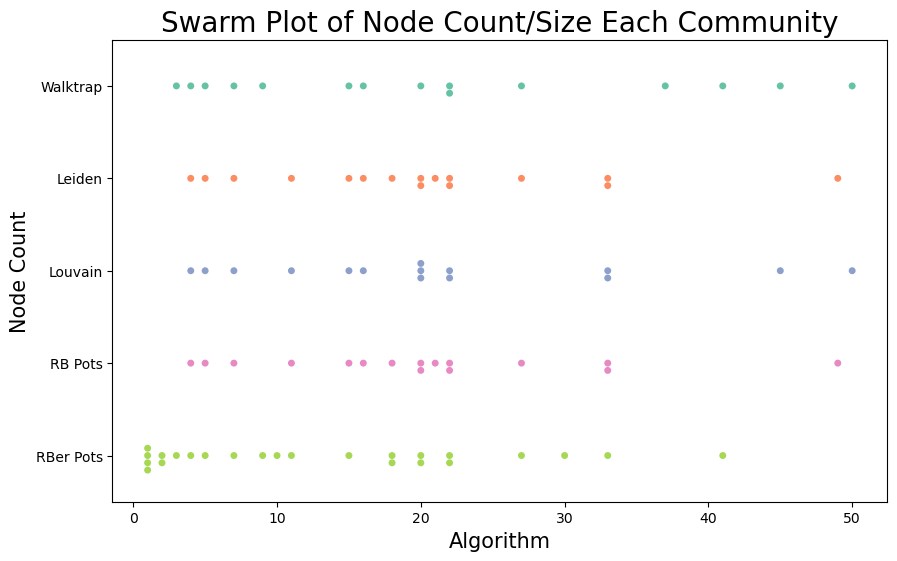

In [98]:
plt.figure(figsize=(10,6))
sns.swarmplot(x='Size', y='Algorithm', data=algo_size, palette='Set2')
plt.title('Swarm Plot of Node Count/Size Each Community', fontsize=20)
plt.xlabel('Algorithm', fontsize=15)
plt.ylabel('Node Count', fontsize=15)
plt.show()

### 18.b. Swarm Plot of Edges Size Each Algorithm

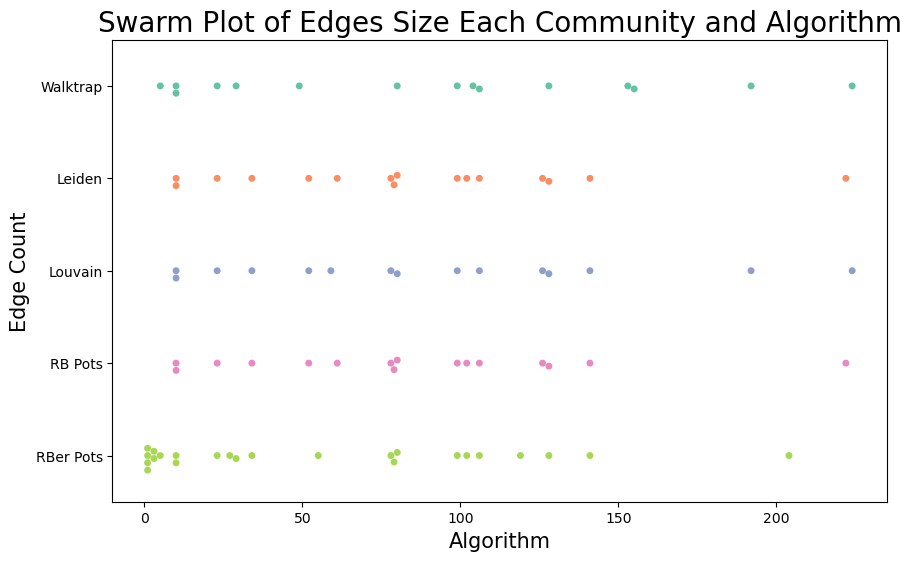

In [99]:
plt.figure(figsize=(10,6))
sns.swarmplot(x='Edge', y='Algorithm', data=algo_edge, palette='Set2')
plt.title('Swarm Plot of Edges Size Each Community and Algorithm', fontsize=20)
plt.xlabel('Algorithm', fontsize=15)
plt.ylabel('Edge Count', fontsize=15)
plt.show()

### 18.c. Swarm Plot of Scaled Density Each Algorithm

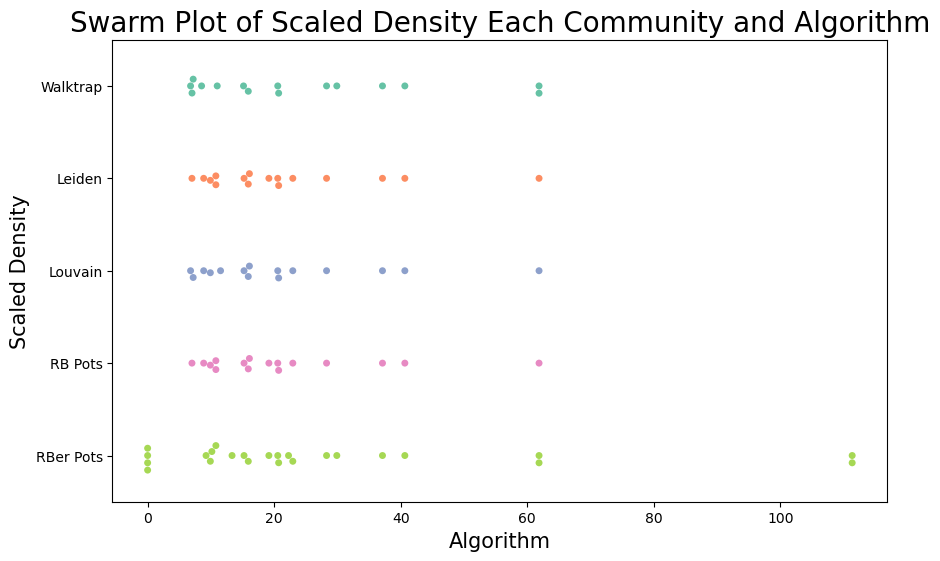

In [100]:
plt.figure(figsize=(10,6))
sns.swarmplot(x='SD', y='Algorithm', data=algo_sd, palette='Set2')
plt.title('Swarm Plot of Scaled Density Each Community and Algorithm', fontsize=20)
plt.xlabel('Algorithm', fontsize=15)
plt.ylabel('Scaled Density', fontsize=15)
plt.show()

In [101]:
algo_size_sg = pd.DataFrame(sg_size, columns=["Algorithm", "Size"])
algo_size_gn = pd.DataFrame(gn_size, columns=["Algorithm", "Size"])
algo_size_bel = pd.DataFrame(bel_size, columns=["Algorithm", "Size"])
algo_size_2 = pd.concat([algo_size_sg, algo_size_gn, algo_size_bel])
algo_size_2.to_excel("13-10-2023_AlgoSize.xlsx")
algo_size_2

Algorithm  Size
0       Spinglass    48
1       Spinglass    45
2       Spinglass    33
3       Spinglass    33
4       Spinglass    22
5       Spinglass    22
6       Spinglass    20
7       Spinglass    20
8       Spinglass    20
9       Spinglass    15
10      Spinglass    11
11      Spinglass     9
12      Spinglass     7
13      Spinglass     7
14      Spinglass     6
15      Spinglass     5
0   Girvan Newman    92
1   Girvan Newman    75
2   Girvan Newman    68
3   Girvan Newman    45
4   Girvan Newman    22
5   Girvan Newman    21
0          Belief    61
1          Belief    60
2          Belief    59
3          Belief    49
4          Belief    38
5          Belief    31
6          Belief    25

In [102]:
algo_edge_sg = pd.DataFrame(sg_edges, columns=["Algorithm", "Edge"])
algo_edge_gn = pd.DataFrame(gn_edges, columns=["Algorithm", "Edge"])
algo_edge_bel = pd.DataFrame(bel_edges, columns=["Algorithm", "Edge"])
algo_edge_2 = pd.concat([algo_edge_sg, algo_edge_gn, algo_edge_bel])
algo_edge_2.to_excel("13-10-2023_AlgoEdge.xlsx")
algo_edge_2

Algorithm  Edge
0       Spinglass   220
1       Spinglass   192
2       Spinglass   126
3       Spinglass   141
4       Spinglass    99
5       Spinglass   128
6       Spinglass    59
7       Spinglass    78
8       Spinglass   106
9       Spinglass    80
10      Spinglass    34
11      Spinglass    29
12      Spinglass    21
13      Spinglass    23
14      Spinglass    11
15      Spinglass    11
0   Girvan Newman   420
1   Girvan Newman   266
2   Girvan Newman   273
3   Girvan Newman   192
4   Girvan Newman   128
5   Girvan Newman   108
0          Belief   277
1          Belief   272
2          Belief   203
3          Belief   222
4          Belief   139
5          Belief   128
6          Belief   116

In [103]:
algo_sd_sg = pd.DataFrame(sg_sd, columns=["Algorithm", "SD"])
algo_sd_gn = pd.DataFrame(gn_sd, columns=["Algorithm", "SD"])
algo_sd_bel = pd.DataFrame(bel_sd, columns=["Algorithm", "SD"])
algo_sd_2 = pd.concat([algo_sd_sg, algo_sd_gn, algo_sd_bel])
algo_sd_2.to_excel("13-10-2023_ScaledDensity.xlsx")
algo_sd_2

Algorithm         SD
0       Spinglass   7.239421
1       Spinglass   7.198737
2       Spinglass   8.857821
3       Spinglass   9.912323
4       Spinglass  15.907923
5       Spinglass  20.567820
6       Spinglass  11.526267
7       Spinglass  15.238116
8       Spinglass  20.708208
9       Spinglass  28.280752
10      Spinglass  22.945974
11      Spinglass  29.901003
12      Spinglass  37.118487
13      Spinglass  40.653581
14      Spinglass  27.220224
15      Spinglass  40.830335
0   Girvan Newman   3.724263
1   Girvan Newman   3.558024
2   Girvan Newman   4.448352
3   Girvan Newman   7.198737
4   Girvan Newman  20.567820
5   Girvan Newman  19.089507
0          Belief   5.618481
1          Belief   5.704084
2          Belief   4.403888
3          Belief   7.007061
4          Belief   7.339217
5          Belief  10.217562
6          Belief  14.352482

### 18.a. Swarm Plot of Size Each Algorithm

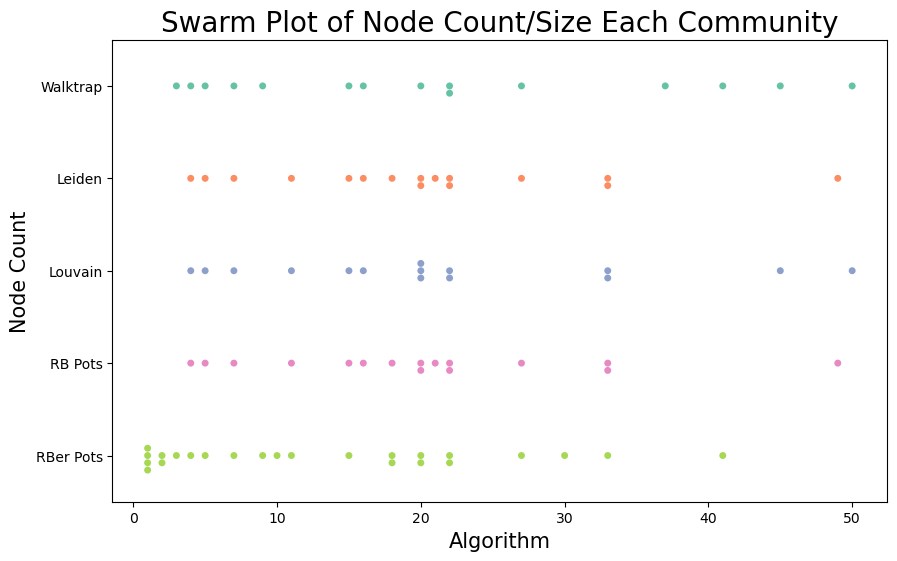

In [104]:
plt.figure(figsize=(10,6))
sns.swarmplot(x='Size', y='Algorithm', data=algo_size, palette='Set2')
plt.title('Swarm Plot of Node Count/Size Each Community', fontsize=20)
plt.xlabel('Algorithm', fontsize=15)
plt.ylabel('Node Count', fontsize=15)
plt.show()

### 18.b. Swarm Plot of Edges Size Each Algorithm

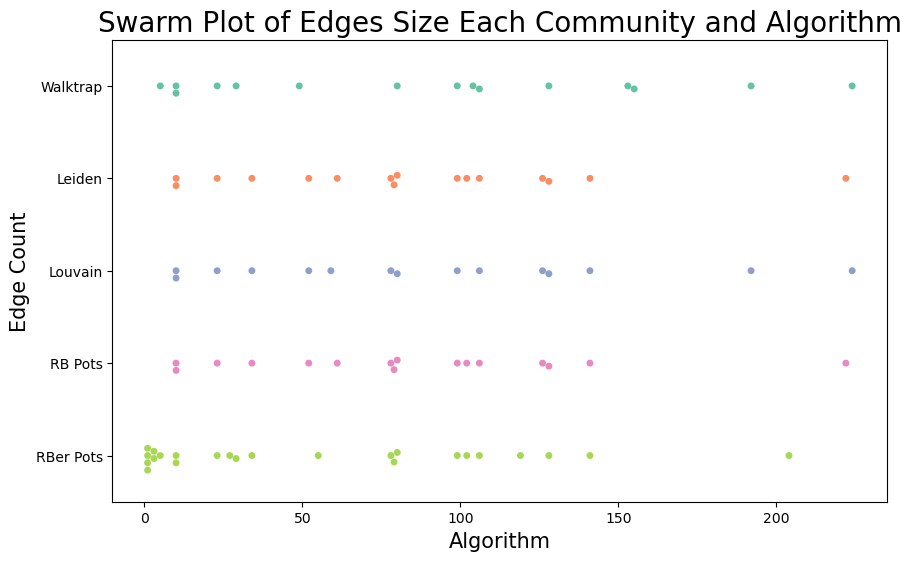

In [105]:
plt.figure(figsize=(10,6))
sns.swarmplot(x='Edge', y='Algorithm', data=algo_edge, palette='Set2')
plt.title('Swarm Plot of Edges Size Each Community and Algorithm', fontsize=20)
plt.xlabel('Algorithm', fontsize=15)
plt.ylabel('Edge Count', fontsize=15)
plt.show()

### 18.c. Swarm Plot of Scaled Density Each Algorithm

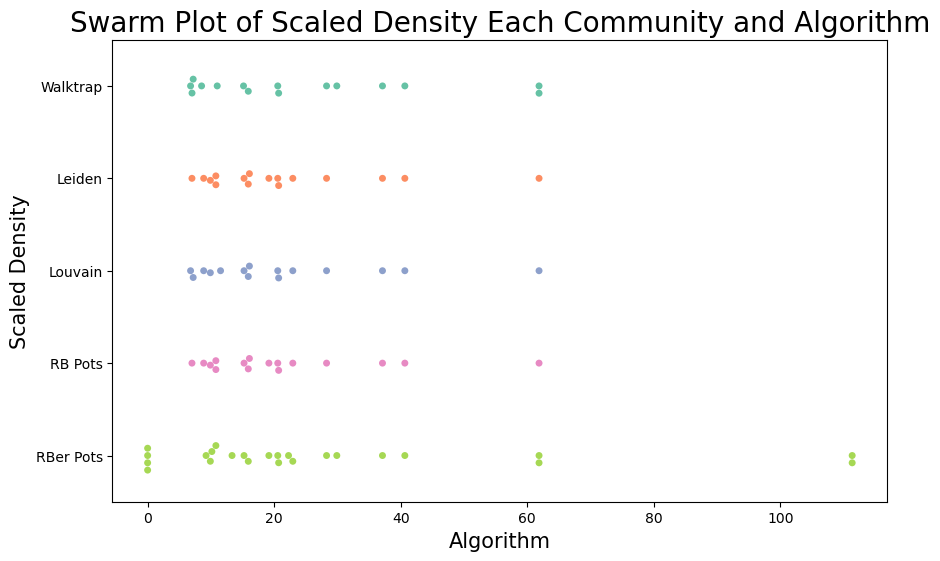

In [106]:
plt.figure(figsize=(10,6))
sns.swarmplot(x='SD', y='Algorithm', data=algo_sd, palette='Set2')
plt.title('Swarm Plot of Scaled Density Each Community and Algorithm', fontsize=20)
plt.xlabel('Algorithm', fontsize=15)
plt.ylabel('Scaled Density', fontsize=15)
plt.show()

### 18.a. Swarm Plot of Size Each Algorithm

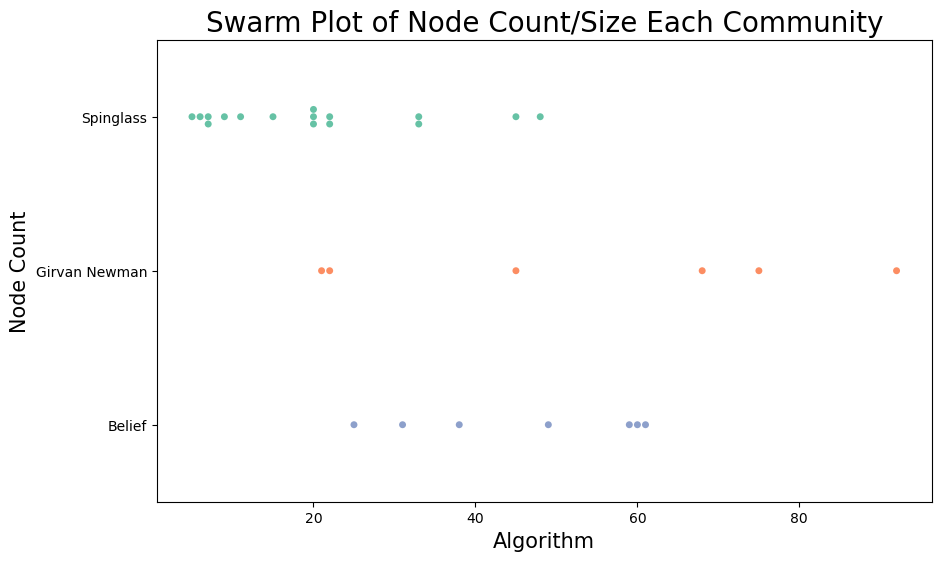

In [107]:
plt.figure(figsize=(10,6))
sns.swarmplot(x='Size', y='Algorithm', data=algo_size_2, palette='Set2')
plt.title('Swarm Plot of Node Count/Size Each Community', fontsize=20)
plt.xlabel('Algorithm', fontsize=15)
plt.ylabel('Node Count', fontsize=15)
plt.show()

### 18.b. Swarm Plot of Edges Size Each Algorithm

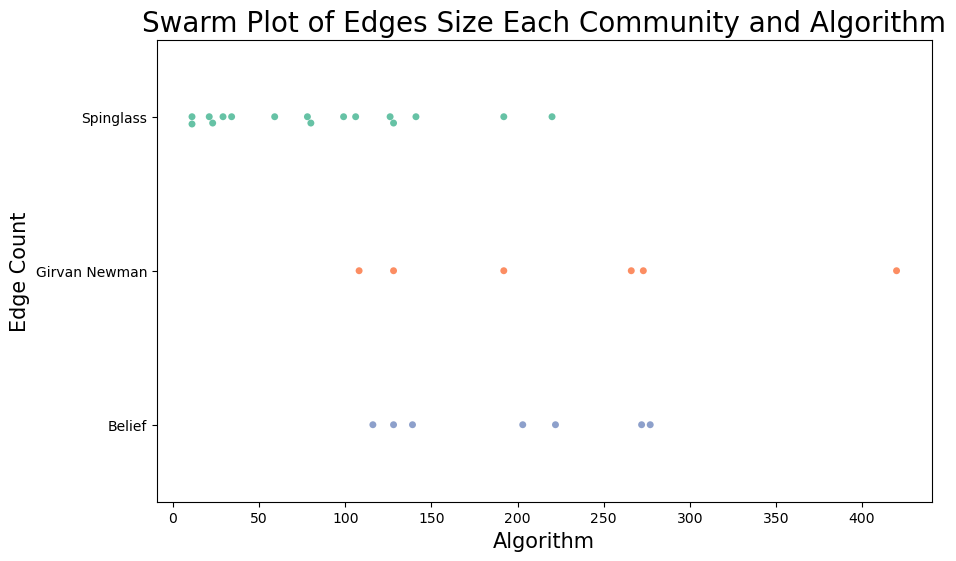

In [108]:
plt.figure(figsize=(10,6))
sns.swarmplot(x='Edge', y='Algorithm', data=algo_edge_2, palette='Set2')
plt.title('Swarm Plot of Edges Size Each Community and Algorithm', fontsize=20)
plt.xlabel('Algorithm', fontsize=15)
plt.ylabel('Edge Count', fontsize=15)
plt.show()

### 18.c. Swarm Plot of Scaled Density Each Algorithm

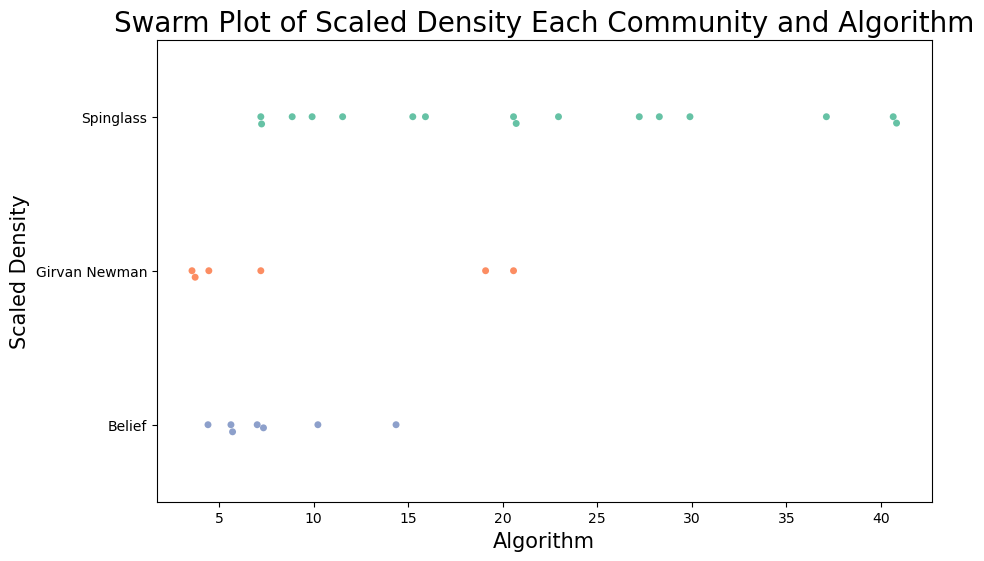

In [109]:
plt.figure(figsize=(10,6))
sns.swarmplot(x='SD', y='Algorithm', data=algo_sd_2, palette='Set2')
plt.title('Swarm Plot of Scaled Density Each Community and Algorithm', fontsize=20)
plt.xlabel('Algorithm', fontsize=15)
plt.ylabel('Scaled Density', fontsize=15)
plt.show()

## === Exploratory or Replication Zone ===

In [110]:
old_data = [[0.548, 0.51, 0.121, 24.106, 1.207],
[0.701, 0.76, 0.14, 59.499, 1.58],
[-0.01, 0, 0, -1964, -0.098],
[0.711, 0.773, 0.135, 70.804, 1.715],
[0.417, 0.491, 0.143, 26.175, 0.844],
[0.707, 0.779, 0.14, 65.678, 1.601],
[0.549, 0.591, 0.136, 34.864, 1.126],
[0.649, 0.723, 0.124, 54.424, 1.587],
[0.703, 0.762, 0.142, 59.117, 1.571],
[0.678, 0.711, 0.132, 61.066, 1.593],
[0, 0.007, 0.144, 6.587, 0],
[0.71, 0.781, 0.134, 73.272, 1.716],
[0.707, 0.757, 0.135, 66.314, 1.683],
[0.711, 0.773, 0.135, 70.804, 1.715],
[0.707, 0.786, 0.14, 68.667, 1.603],
[0.702, 0.79, 0.139, 63.449, 1.597],
[0.711, 0.773, 0.135, 70.804, 1.715],
[0.622, 0.719, 0.118, 5.528, 1.567],
[0.71, 0.781, 0.134, 73.272, 1.716],
[0.697, 0.78, 0.132, 59.834, 1.691],
[0.707, 0.786, 0.14, 68.667, 1.603]]

old_table = pd.DataFrame(old_data, columns=list('abcde'))

scaler = StandardScaler()
pca = PCA(n_components=1)

old_table = scaler.fit_transform(old_table)
model = pca.fit(old_table)
df = model.transform(old_table)
print(df)
print(pca.components_)
print(pca.explained_variance_)

[[ 0.63036584]
 [-0.8501569 ]
 [ 7.72023359]
 [-0.96378273]
 [ 0.98659069]
 [-0.92734612]
 [ 0.32110125]
 [-0.44232859]
 [-0.87742127]
 [-0.60340524]
 [ 3.66887027]
 [-0.96761846]
 [-0.88894562]
 [-0.96378273]
 [-0.94640124]
 [-0.91919019]
 [-0.96378273]
 [-0.22552343]
 [-0.96761846]
 [-0.87345669]
 [-0.94640124]]
[[-0.46840276 -0.46709713 -0.40151169 -0.4294927  -0.46555721]]
[4.31741388]


In [111]:
old_data = [[0.888, 0.721, 0.929, 0.929, 0.929],
[9.125, 8.113, 11.198, 11.198, 11.198],
[0.667, 0.601, 0.838, 0.838, 0.838],
[0.148, 0.3, 0.094, 0.094, 0.094],
[0.008, 0.008, 0.009, 0.009, 0.009],
[101.333, 91.1, 130.571, 130.571, 130.571],
[0.984, 1.04, 1.083, 1.083, 1.083],
[0.27, 0.243, 0.364, 0.364, 0.364],
[0.709, 0.538, 0.603, 0.603, 0.603],
[0.157, 0.308, 0.105, 0.105, 0.105],
[6.333, 5.8, 7.857, 7.857, 7.857],
[0.984, 1.04, 1.083, 1.083, 1.083],
[0.009, 0.208, 0.011, 0.011, 0.011],
[7.437, 5.645, 6.322, 6.322, 6.322],
[16, 14.4, 20.571, 20.571, 20.571],
[0.772, 0.695, 0.971, 0.971, 0.971]]

old_table = pd.DataFrame(old_data, columns=list('abcde'))

scaler = StandardScaler()
pca = PCA(n_components=1)

old_table = scaler.fit_transform(old_table)
model = pca.fit(old_table)
df = model.transform(old_table)
print(df)
print(pca.components_)
print(pca.explained_variance_)

[[-0.7552945 ]
 [-0.0102547 ]
 [-0.76575066]
 [-0.81347135]
 [-0.82570948]
 [ 8.5246021 ]
 [-0.74035117]
 [-0.80079594]
 [-0.77636085]
 [-0.81266833]
 [-0.252832  ]
 [-0.74035117]
 [-0.82149388]
 [-0.30154011]
 [ 0.64844006]
 [-0.75616801]]
[[0.44716949 0.44722784 0.44722355 0.44722355 0.44722355]]
[5.33279792]
